In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
#where is TRAPPIST-1
c = SkyCoord(ra=346.62652162764437*u.degree, dec=-5.043528319429532*u.degree,
             pm_ra_cosdec=930.7875225817781*u.mas/u.yr, pm_dec=-479.0375409528857*u.mas/u.yr,frame='icrs',obstime=Time('2016-01-01 00:00:00.0'))
c.apply_space_motion(dt=7.5 * u.year)

/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<SkyCoord (ICRS): (ra, dec) in deg
    (346.62846831, -5.04452631)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (930.78895221, -479.0347598, 0.1141666)>

In [3]:
wfc3 = glob.glob('results/*wfc3_p*')
wfc3.sort()
wfc3

['results/epoch1_wfc3_photometry.ecsv',
 'results/epoch2_wfc3_photometry.ecsv',
 'results/epoch3_wfc3_photometry.ecsv']

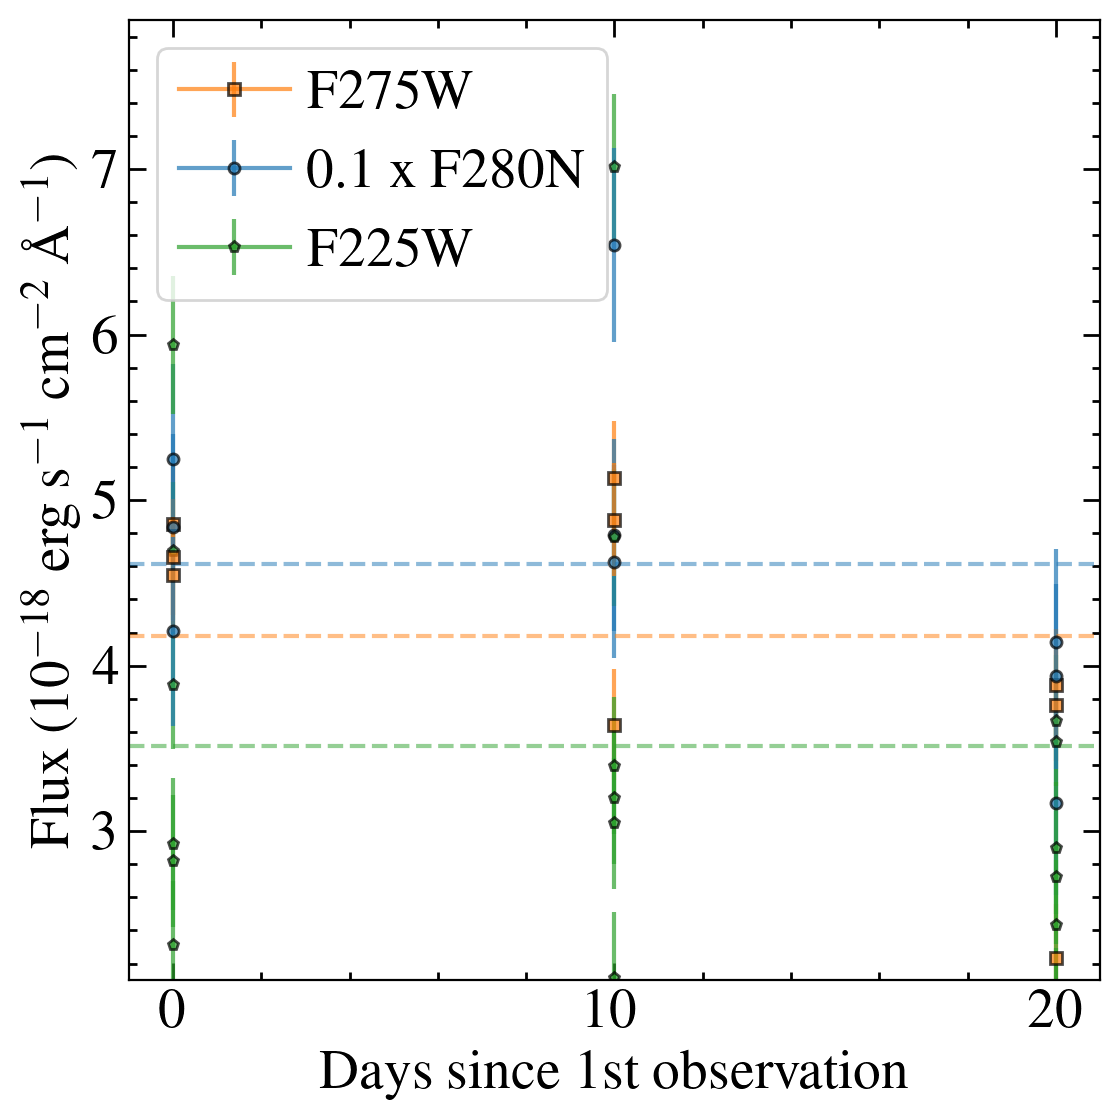

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# cols = [0, 1, 2]

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
            f280n.append(row['FLUX'])
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
            f275w.append(row['FLUX'])
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'
            f225w.append(row['FLUX'])
            
        if row['FILTER'] == 'F280N':
            ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                        marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        else:
            ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)

ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since 1st observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=2) 

fig.tight_layout()
fig.savefig('plots/wfc3_all_visits.pdf')

In [5]:
alldays = np.array([], dtype=float)

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    alldays = np.hstack((alldays, data['EXPSTART']))
    
alldays
d1 = np.min(alldays)

In [6]:
# 0.18--0.03
# 10.15-9.95
20.31-20.11

0.1999999999999993

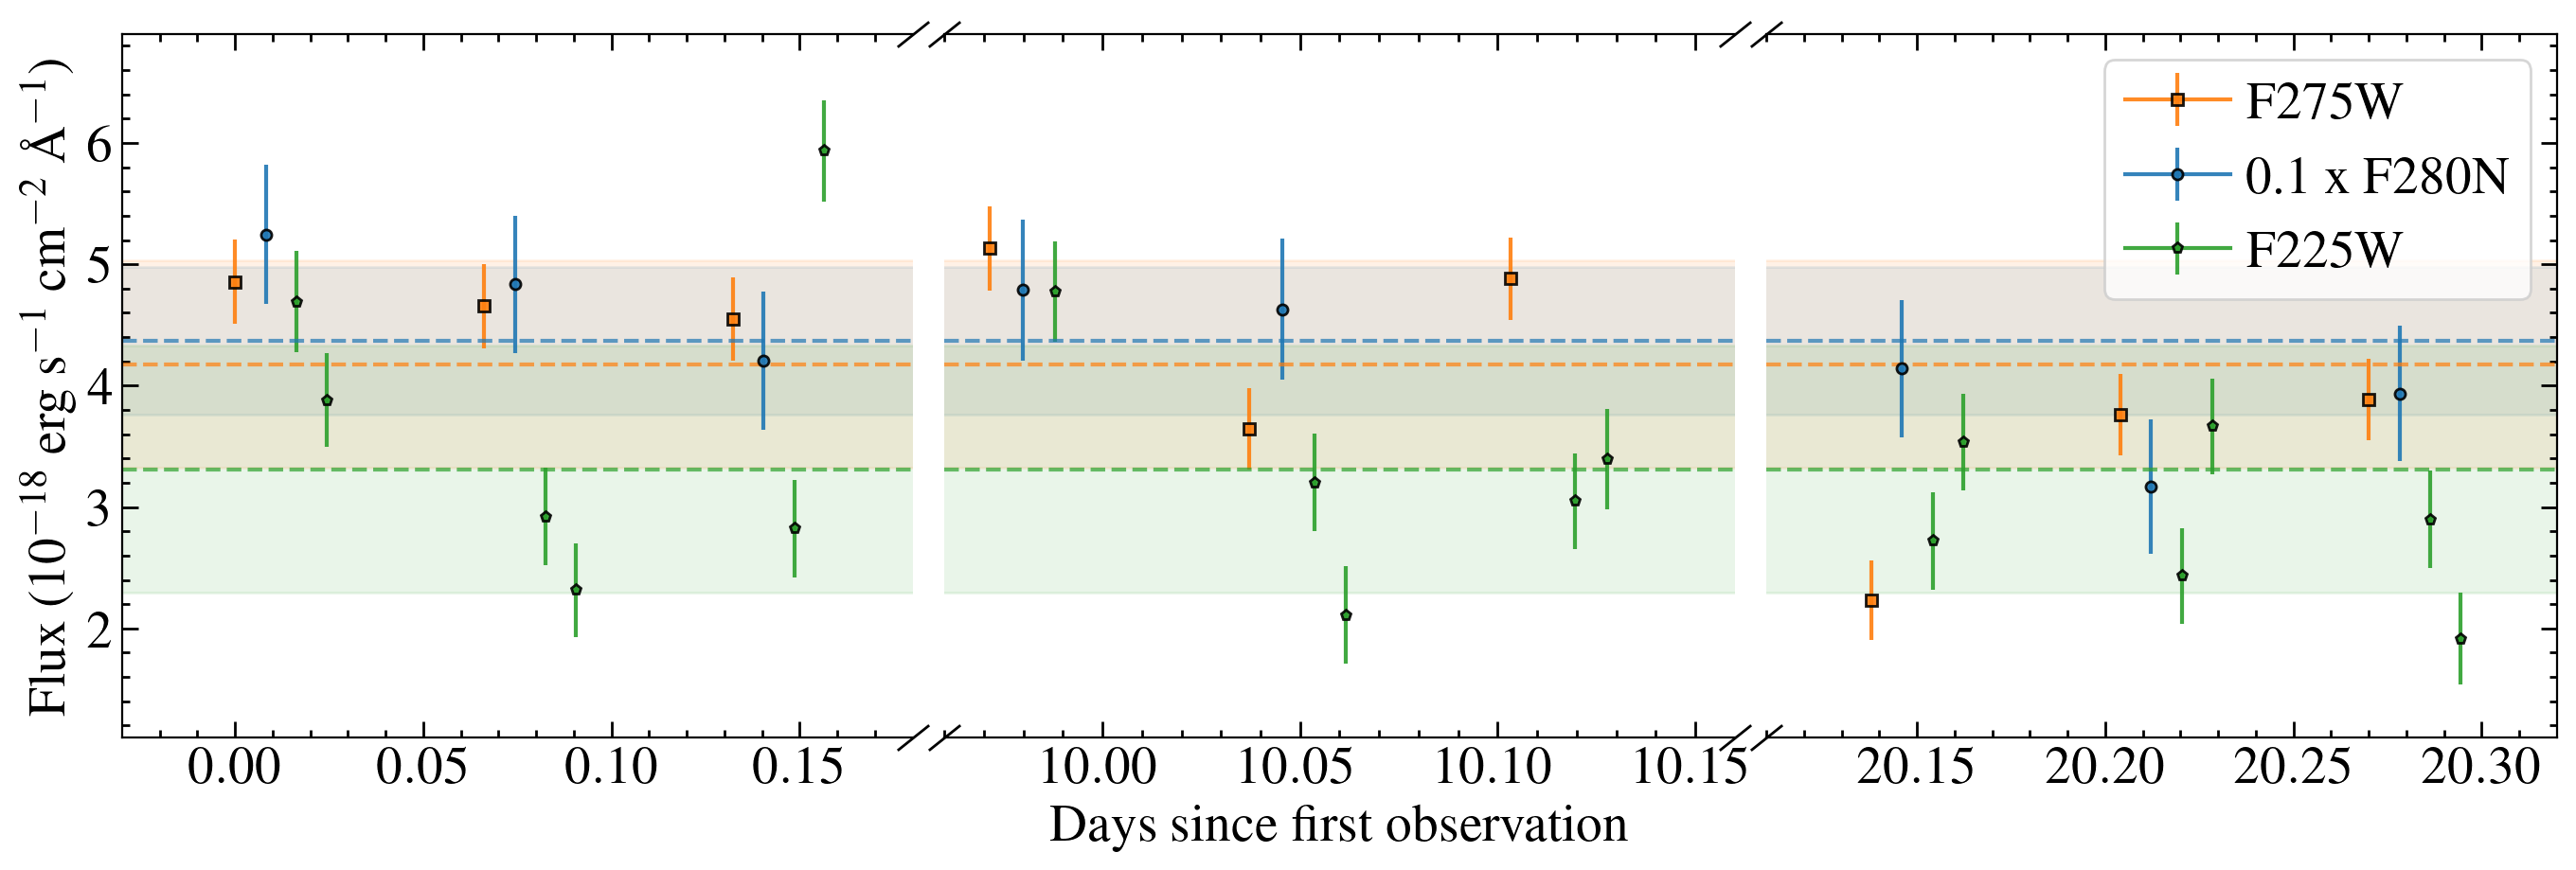

In [7]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax1.set_xlim(-0.03, 0.18) 
ax2.set_xlim(9.96, 10.16)  
ax3.set_xlim(20.11, 20.32)  

ax1.set_ylim(1.1, 6.9)

# hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
ax1.spines.right.set_visible(False)
ax1.yaxis.tick_left()

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
# ax2.tick_params(labelright=False)
# ax2.yaxis.tick_left()
# ax2.yaxis.tick_right()
# ax2.tick_params(labelcolor='none', left=False, right=False, which='both')
ax2.tick_params(right = False, left=False, which='both')
# ax2.set_yticks([])

ax3.spines.left.set_visible(False)
ax3.yaxis.tick_right()
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()

# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])

            if row['FILTER'] == 'F280N':
                ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

            else:
                ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
                ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

x = np.arange(-5, 30)
ax1.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax1.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax1.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
ax1.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax1.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax1.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)


ax2.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax2.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax2.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
ax2.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax2.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax2.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)

ax3.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.7, c='C0')
ax3.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax3.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax3.fill_between(x, (np.mean(f280n)-np.std(f280n))*scale/10, (np.mean(f280n)+np.std(f280n))*scale/10, color='C0', alpha=0.1)
ax3.fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax3.fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
# # ax.set_yscale('log')
# ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax.set_xlabel('Days since 1st observation')
# ax.set_xticks(days)

# # ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax1.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax2.set_xlabel('Days since first observation')

fig.tight_layout()
fig.subplots_adjust(wspace=0.04)  # adjust space between axes



# plt.show()

# plt.savefig('plots/t1_flcs_lc.pdf')


Phase fold onto rotation period? Basically useless with that error on the rotation period, need TESS.

In [8]:
# prot = 3.3  # +/- 14,  Ducrot et al 2020 

# fig, ax = plt.subplots()

# for i, phot in enumerate(wfc3):
#     data = Table.read(phot)
#     for row in data:
#         if row['FILTER'] == 'F280N':
#             c = 'C0'
#             m = 'o'
#         elif row['FILTER'] == 'F275W':
#             c = 'C1'
#             m ='s'
#         elif row['FILTER'] == 'F225W':
#             c = 'C2'
#             m ='p'
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(((row['EXPSTART']/prot) % 1), row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(((row['EXPSTART']/prot) % 1), row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)



In [9]:
drcs = glob.glob('results/epoch*_wfc3_drc_photometry.ecsv')
drcs.sort()
drcs

['results/epoch1_wfc3_drc_photometry.ecsv',
 'results/epoch2_wfc3_drc_photometry.ecsv',
 'results/epoch3_wfc3_drc_photometry.ecsv']

In [10]:
wfc3

['results/epoch1_wfc3_photometry.ecsv',
 'results/epoch2_wfc3_photometry.ecsv',
 'results/epoch3_wfc3_photometry.ecsv']

results/epoch1_wfc3_photometry.ecsv


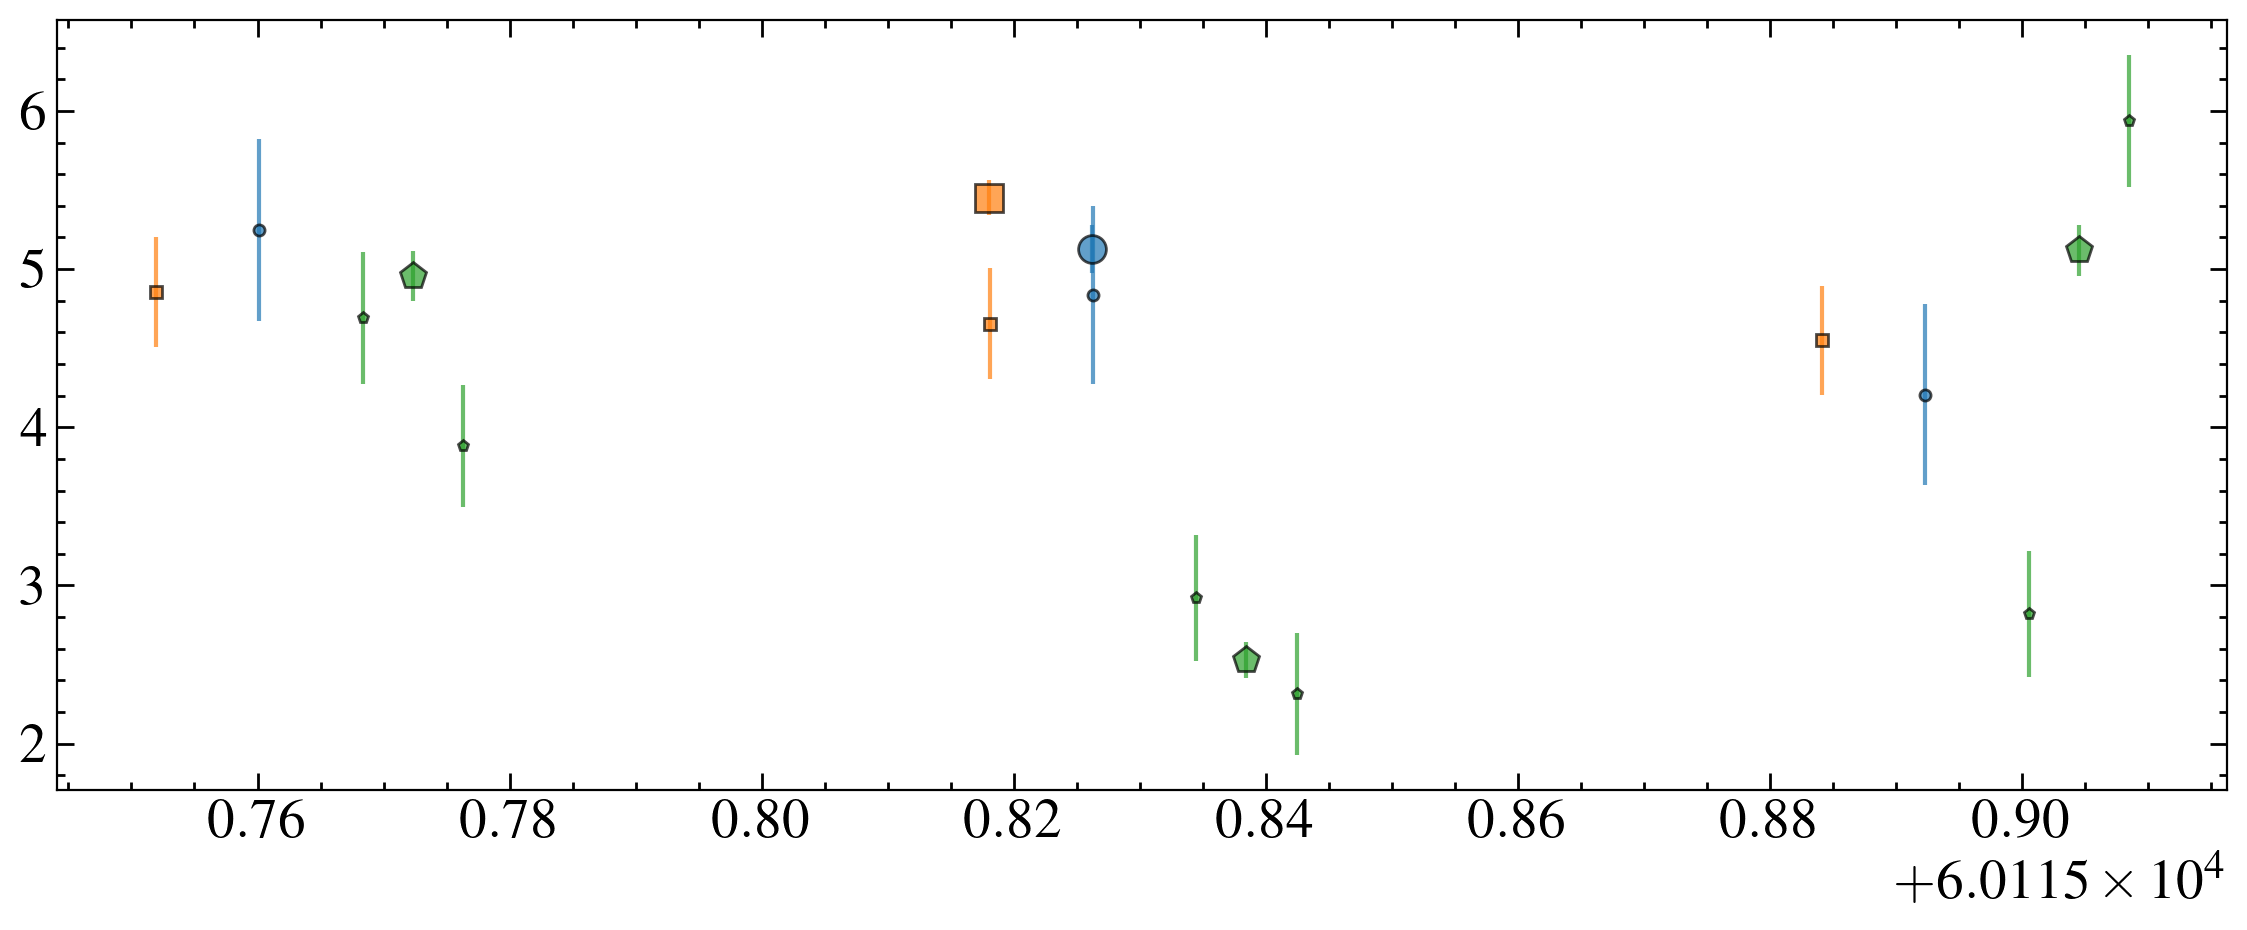

results/epoch2_wfc3_photometry.ecsv


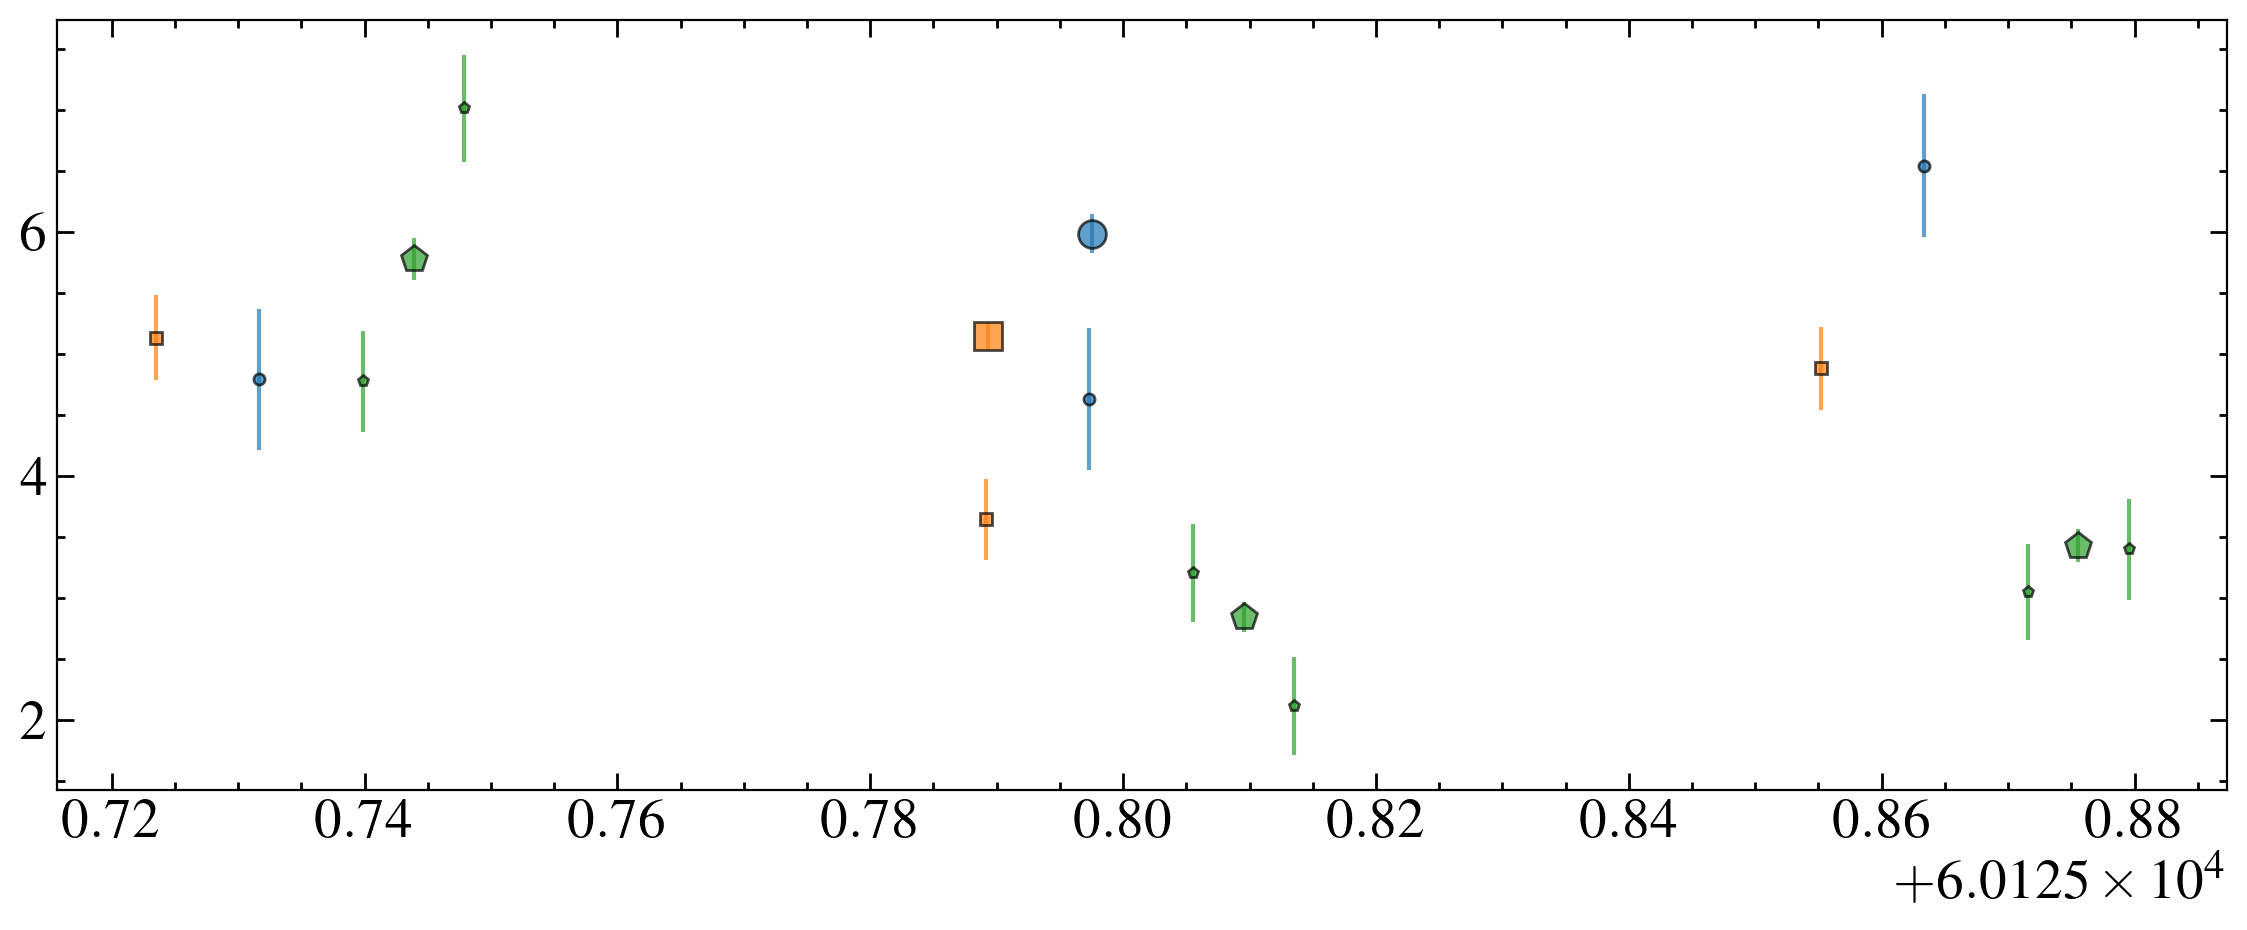

results/epoch3_wfc3_photometry.ecsv


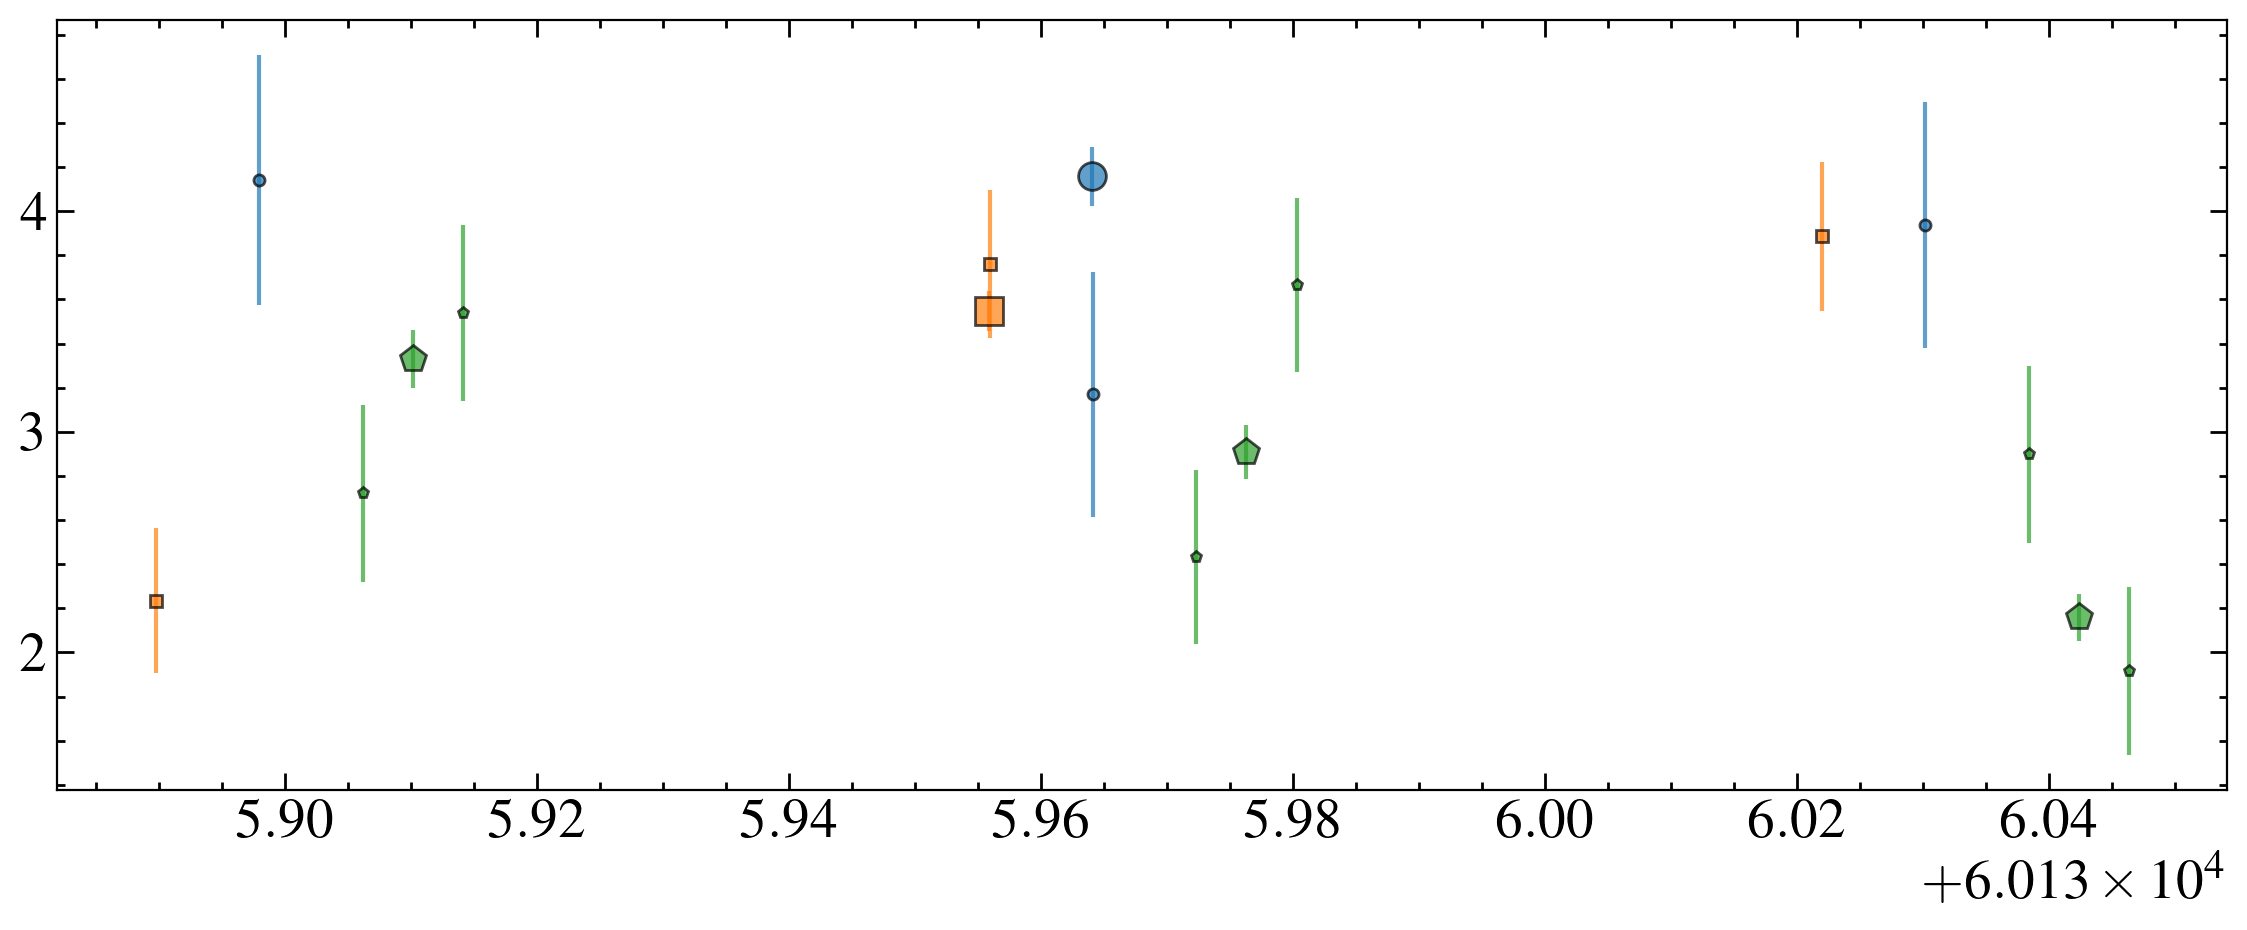

In [11]:

for i, phot in enumerate(wfc3):
    print(phot)
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

        if row['FILTER'] == 'F280N':
            ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                        marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        else:
            ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)

    data = Table.read(drcs[i])
    for row in data:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'

            if row['FILTER'] == 'F280N':
                ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
                            marker=m, c=c, markeredgecolor='k', markersize=10, alpha=0.7)
            else:
                ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['FLUX']*scale, yerr=row['ERROR']*scale,
                            label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=10, alpha=0.7)
    plt.show()
            



Need to look into other late M dwarfs and see what their NUV spectra look like. LHS2686 is M5. Turns out a flat spectrum is legit?

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const1D(amplitude=0.)>

    [1]: <Gaussian1D(amplitude=0., mean=2797.52959477, stddev=1.48588478)>

    [2]: <Gaussian1D(amplitude=0., mean=2804.70759477, stddev=2.44957783)>

    [3]: <BlackBody(temperature=7933.92528247, scale=0.)>

    [4]: <Gaussian1D(amplitude=0., mean=2381.24185023, stddev=27.85042034)>

    [5]: <Gaussian1D(amplitude=0., mean=2617.75646478, stddev=16.50889674)>
Parameters:
    amplitude_0     amplitude_1      ...       mean_5            stddev_5     
    ----------- -------------------- ... ------------------ ------------------
            0.0 4.94193998810127e-15 ... 2617.7564647770732 16.508896744462866


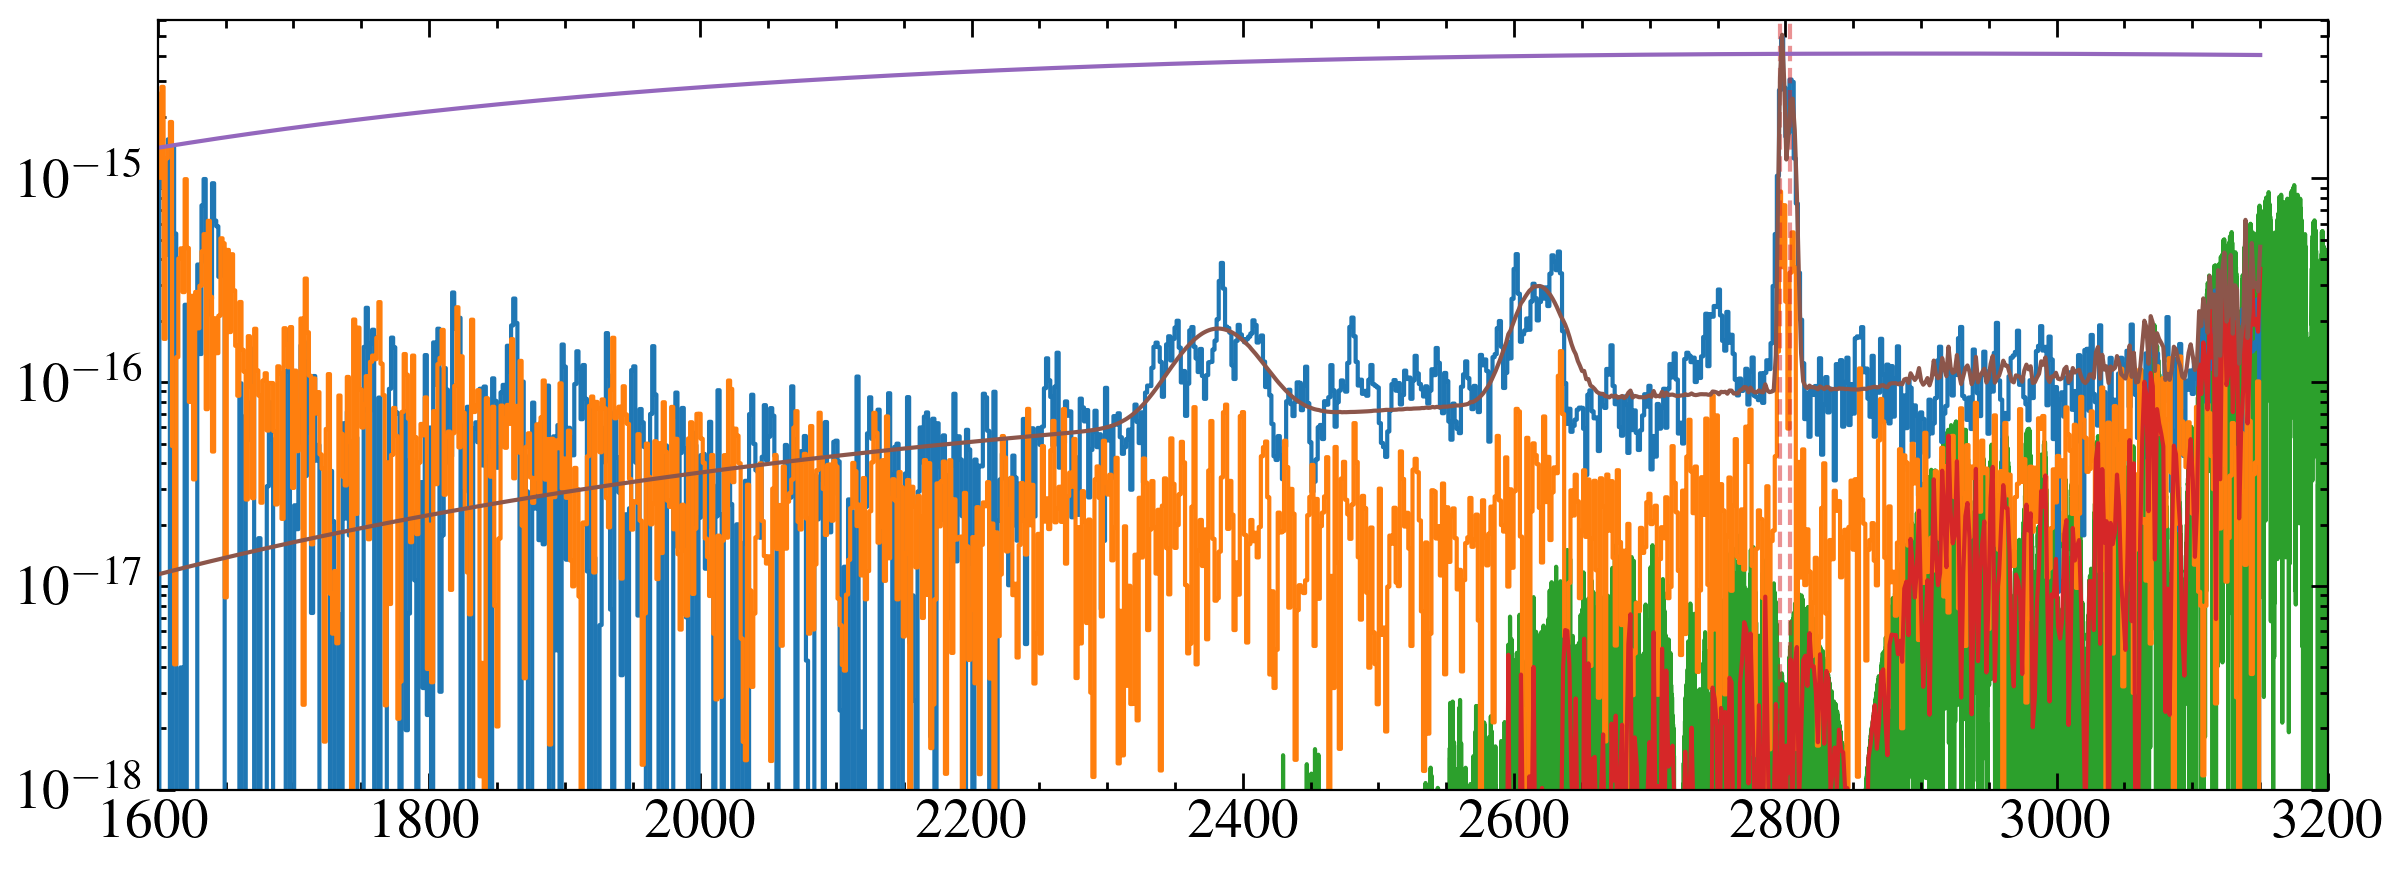

In [12]:
fig, ax = plt.subplots()

m6path ='/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/LHS-2686/'
phx = 'hlsp_muscles_model_phx_lhs-2686_na_v24_component-spec.fits'
nuv = 'hlsp_muscles_hst_stis_lhs-2686_g230l_v24_component-spec.fits'

ndata = fits.getdata(m6path+nuv,1)
wn, fn, en = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
ax.step(wn, fn, where='mid')
ax.step(wn, en, where='mid')

pdata = fits.getdata(m6path+phx,1)
norm = fits.getheader(m6path+phx)['NORMFAC']
wp, fp = pdata['WAVELENGTH'], pdata['FLUX']*norm
ax.plot(wp, fp, zorder=-1)

pfi = interp1d(wp, fp, fill_value='extrapolate')(wn)
ax.plot(wn, pfi)

fitter = fitting.LevMarLSQFitter()

mg2 = [2796.352, 2803.53]
os = [6.08e-01, 3.03e-01]

lines = np.copy(mg2)

mod = models.Const1D(0, fixed=dict(amplitude=True))
for line in lines:
    line_guess = (-50*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
    mod = mod+  models.Gaussian1D(amplitude=np.max(fn)/2, mean = line_guess, stddev=0.5)
    # mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1, bounds=dict(amplitude_L=[0, 1]))
    # plt.axvline(line, ls='--', c='C2', alpha =0.5)
    plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

def tiedfunc0(mod):
    mean = mod.mean_1.value+np.diff(lines)
    return mean

def tiedfunc1(mod):
    x_0 = mod.x_0_1.value+np.diff(lines)
    # fwhm_G = mod.fwhm_G_1.value
    return x_0

def tiedfwhmg(mod):
    fwhm_G = mod.fwhm_G_1.value
    return fwhm_G

def tiedfwhml(mod):
    fwhm_L = mod.fwhm_L_1.value
    return fwhm_L

def tiedamp(mod):
    amplitude = mod.amplitude_1.value/(os[0]/os[1])
    return amplitude

mod.mean_2.tied=tiedfunc0
mod.amplitude_2.tied = tiedamp

#blackbody

bb_init = models.BlackBody(temperature=10000*u.K, scale=1e-22*u.erg/u.s/u.cm**2/u.AA/u.sr, bounds = dict(temperature=(2000, 20000)))

ax.plot(wn, bb_init(wn))

mod = mod+bb_init

#fe regions
femod =  models.Gaussian1D(amplitude=0.5e-15, mean = 2360, stddev=50) + models.Gaussian1D(amplitude=0.5e-15, mean = 2600, stddev=10)
# femod =  models.Box1D(amplitude=1e-16, x_0 = 2360, width=50) + models.Box1D(amplitude=1e-16, x_0 = 2600, width=70)

mod = mod+femod


mask = (wn > 2000) & (wn < 3100) #& (fn > 0)

gg_fit = fitter(mod, wn[mask], fn[mask]-pfi[mask], maxiter=100000)#, weights = 1/en[mask])

print(gg_fit)




# if type(fitter.fit_info['param_cov']) == np.ndarray:
# #     print('hooray!')
#     fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#     print(fit_e)
    
ax.plot(wn, gg_fit(wn)+pfi)
# gg_fit




ax.set_yscale('log')

ax.set_xlim(1600, 3200)
ax.set_ylim(1e-18, 6e-15)

final_mod = gg_fit[3](wn) + gg_fit[4](wn)+gg_fit[5](wn)

savdat = Table([wn, final_mod], names=['WAVELENGTH', 'FLUX'])
savdat.write('model_spectra/lhs2686_nuv_model.ecsv', format='ascii.ecsv', overwrite=True)

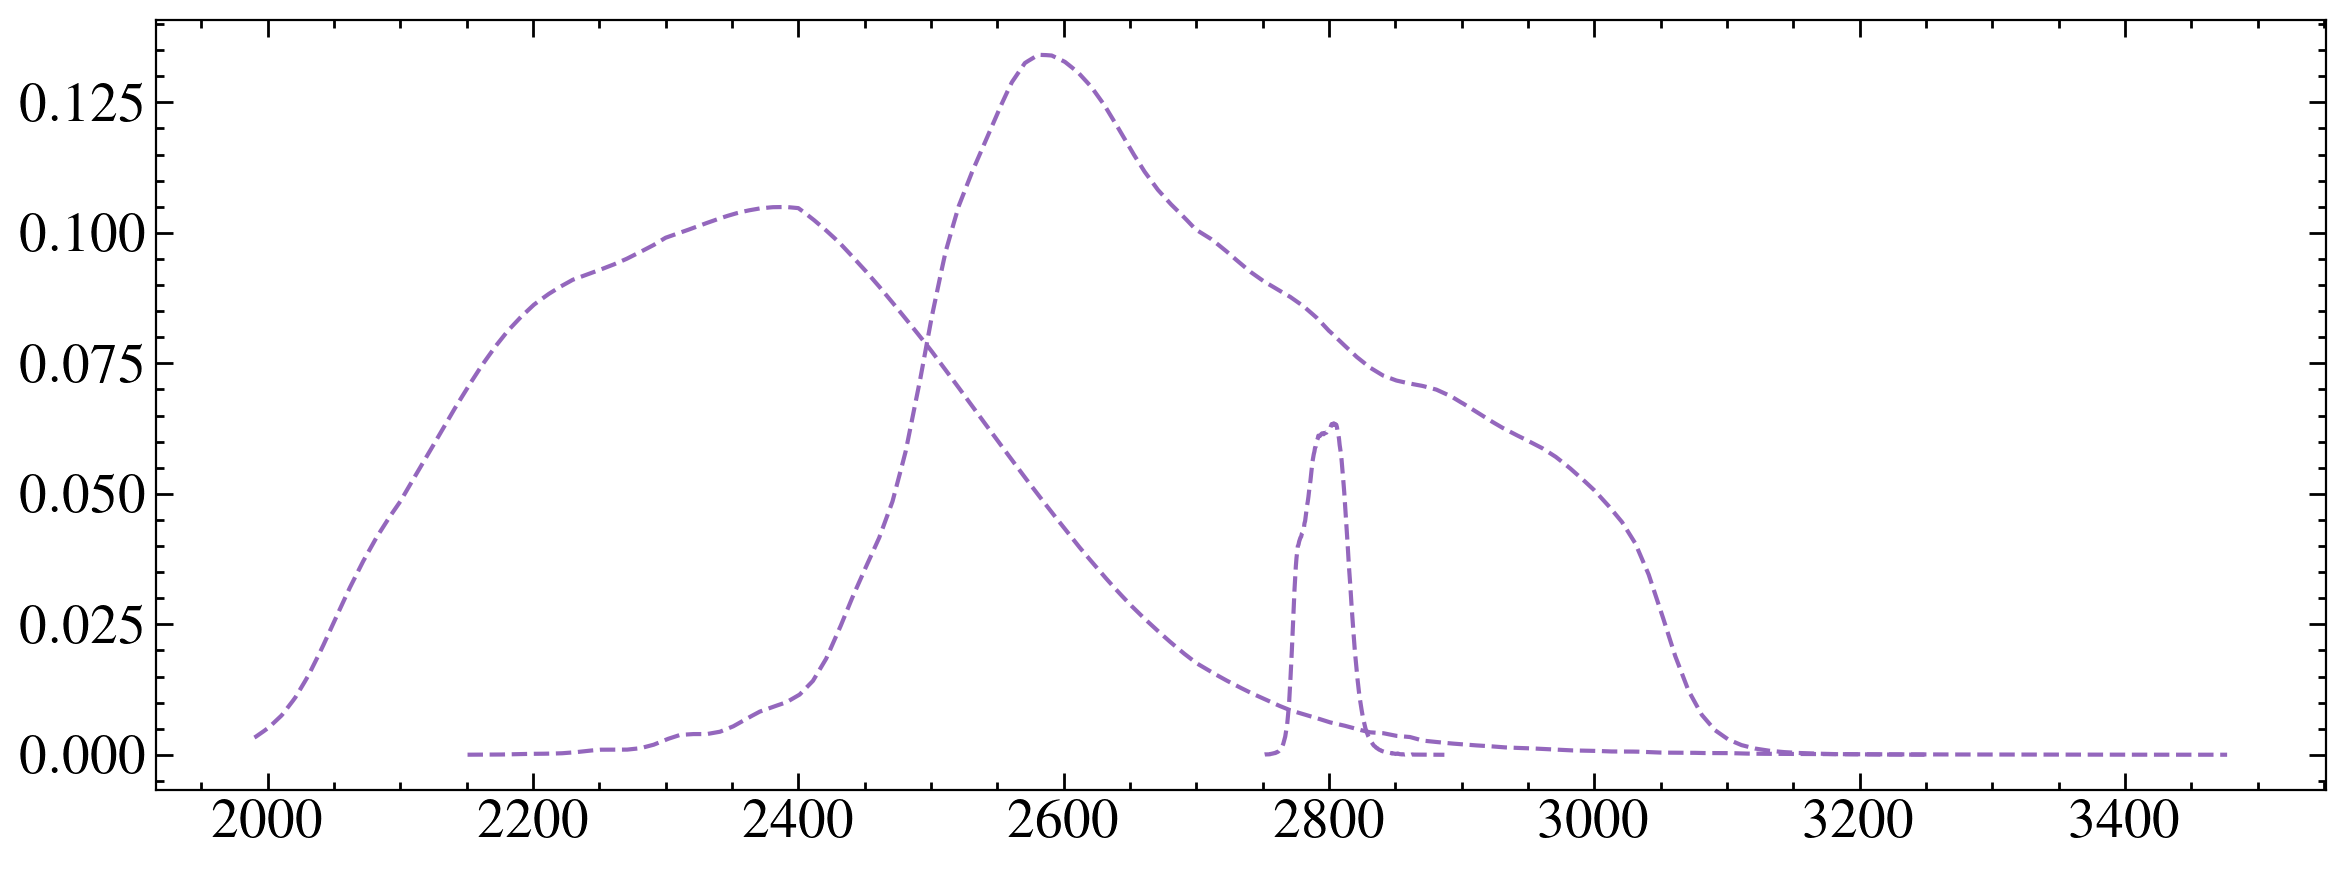

In [13]:
bands= glob.glob('filters/*UVIS*')
for band in bands:
    bpw, bpf = np.loadtxt(band, unpack=True)
    plt.plot(bpw, bpf, ls ='--', c='C4', label = 'Transmission Profiles')

Check bakground fluxes

In [14]:
data.dtype.names

('EXPSTART',
 'EXPEND',
 'EXPTIME',
 'FILTER',
 'FLUX',
 'ERROR',
 'ROOTNAME',
 'COUNTS',
 'COUNTS_ERROR',
 'BACKGROUND')

results/epoch1_wfc3_photometry.ecsv
results/epoch2_wfc3_photometry.ecsv
results/epoch3_wfc3_photometry.ecsv


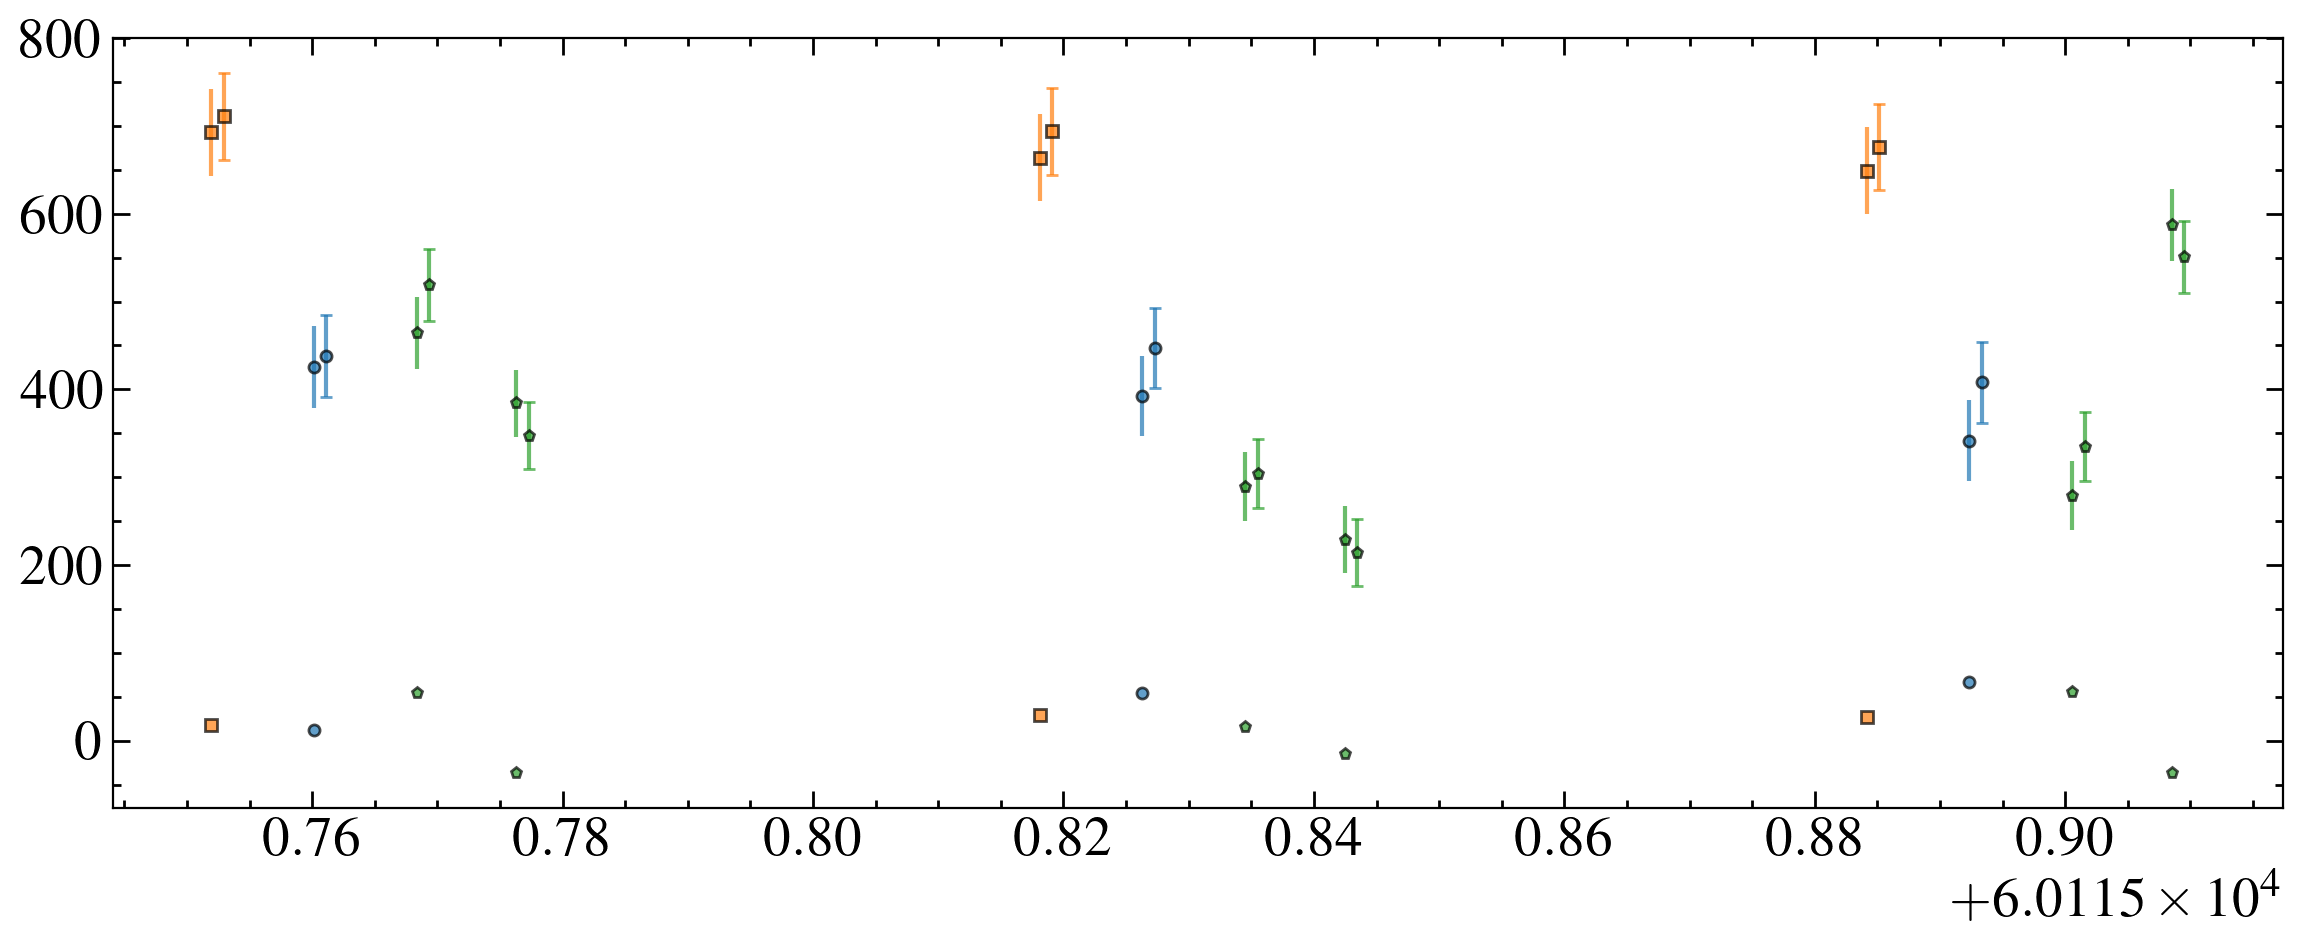

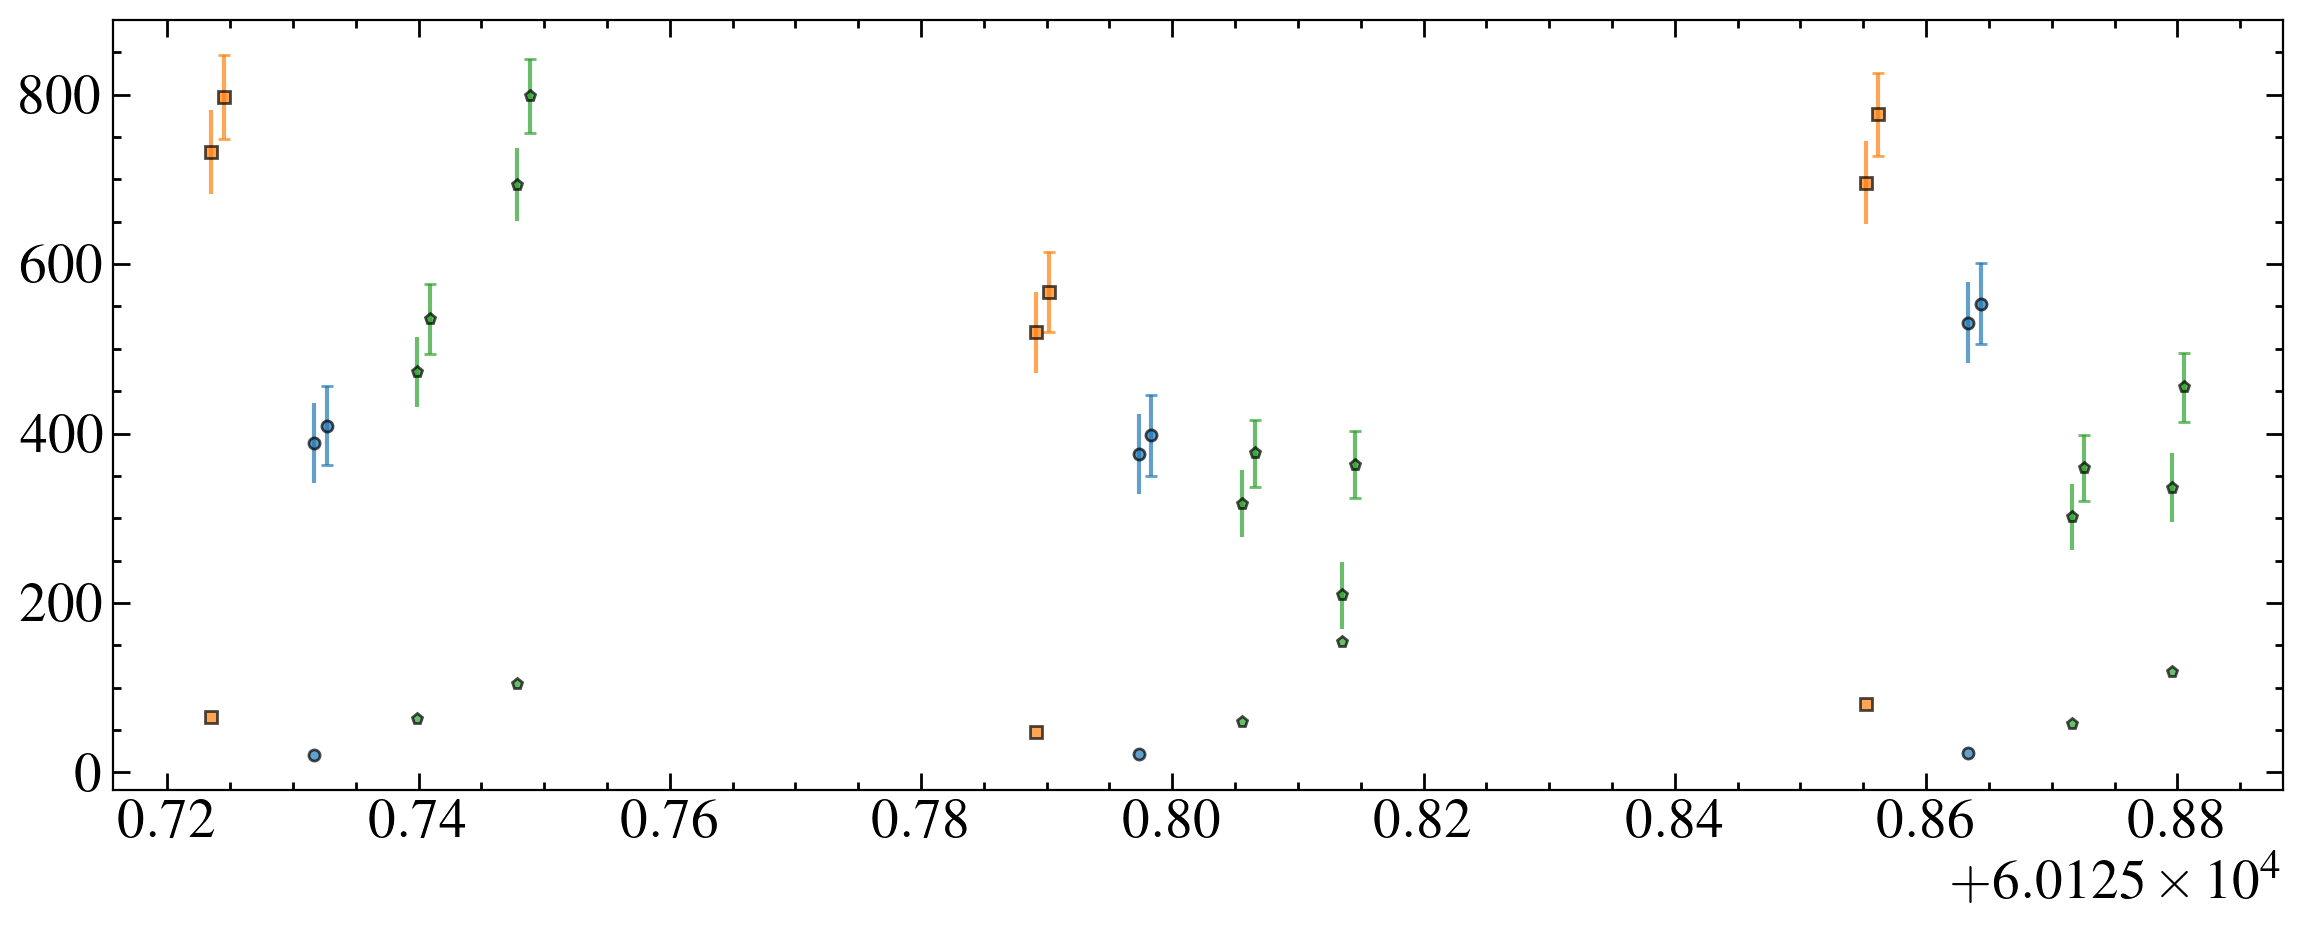

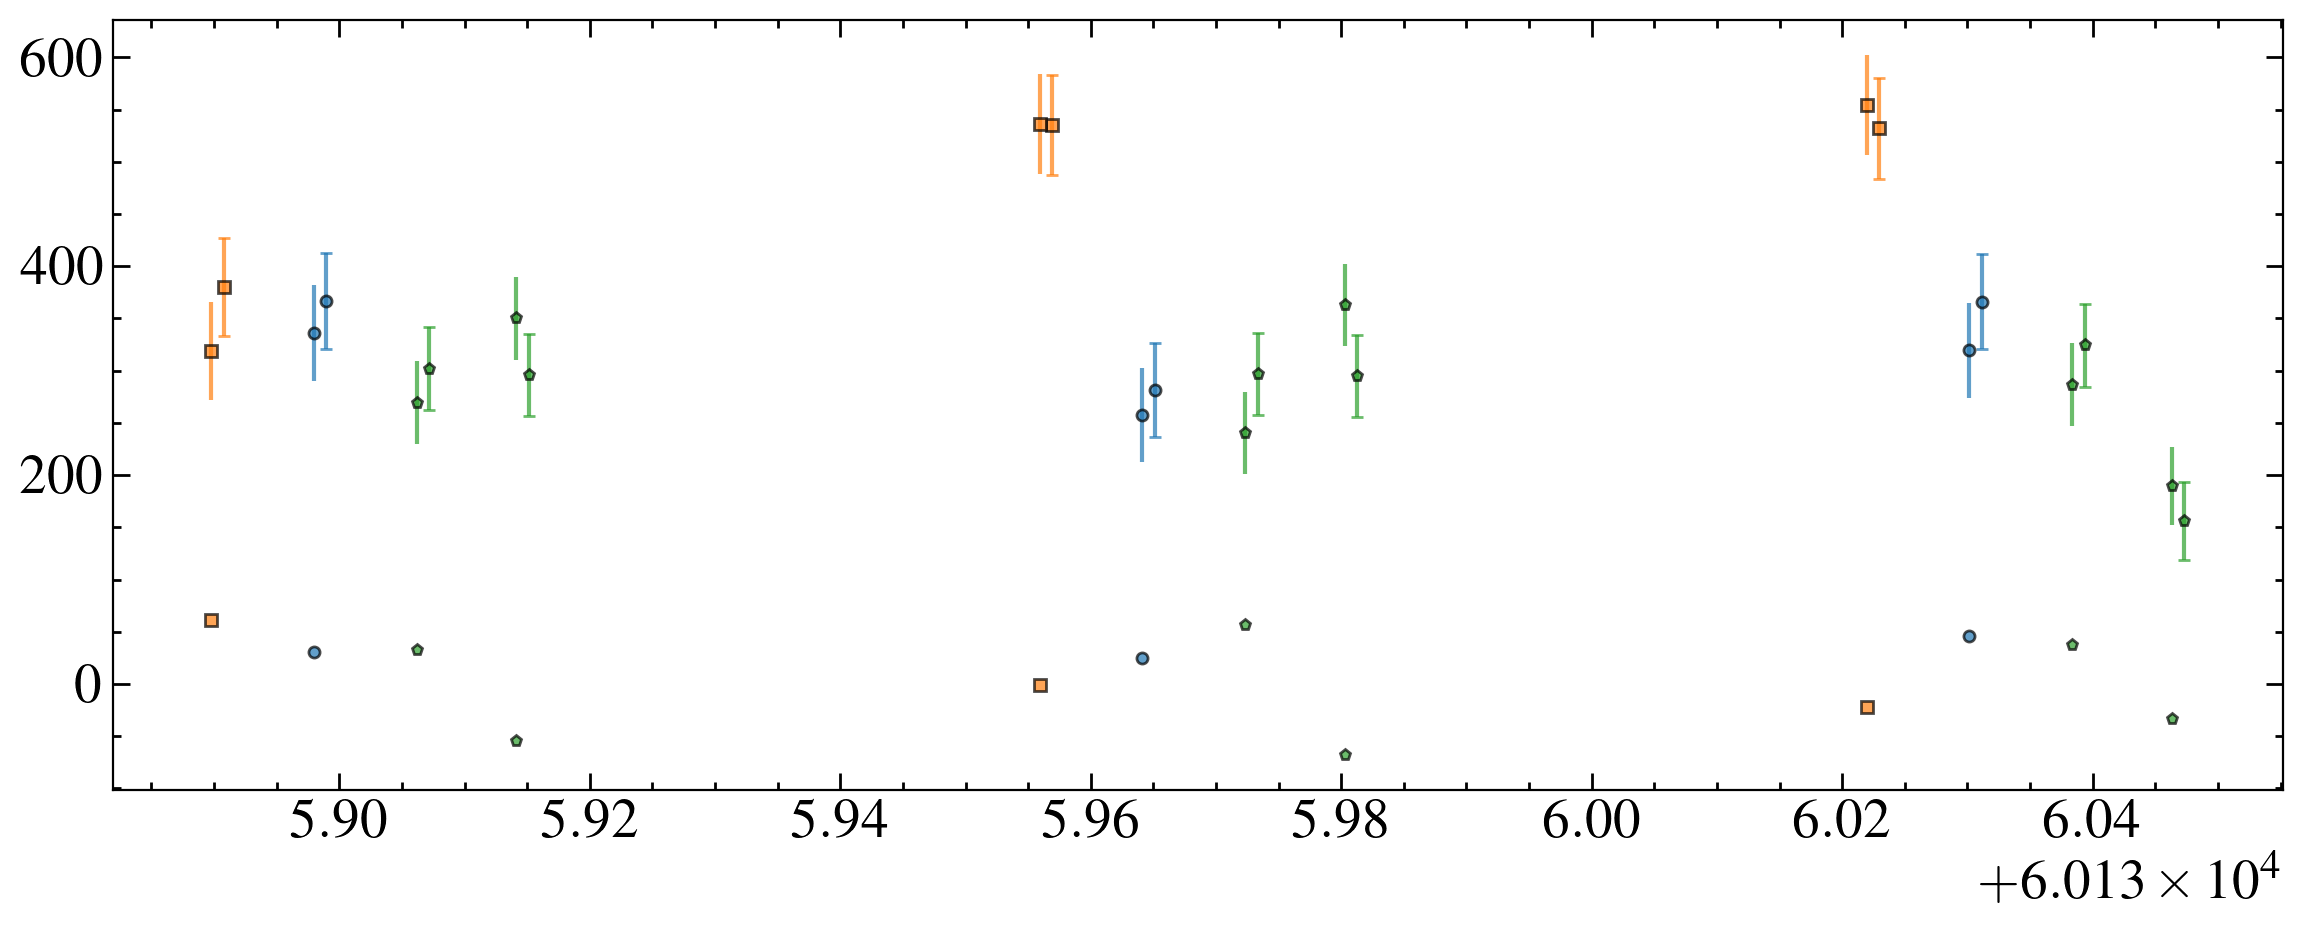

In [15]:
for i, phot in enumerate(wfc3):
    print(phot)
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

   
        ax.errorbar(((row['EXPSTART']+row['EXPEND'])/2)+0.001, row['COUNTS']+row['BACKGROUND'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], 
                    marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7, capsize=2)
        ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['COUNTS'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['BACKGROUND'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)


            



fitted orbit = 94.72983525947083 min
real orbit = 94.9917376076 min
difference =  -0.27647292683641067 %


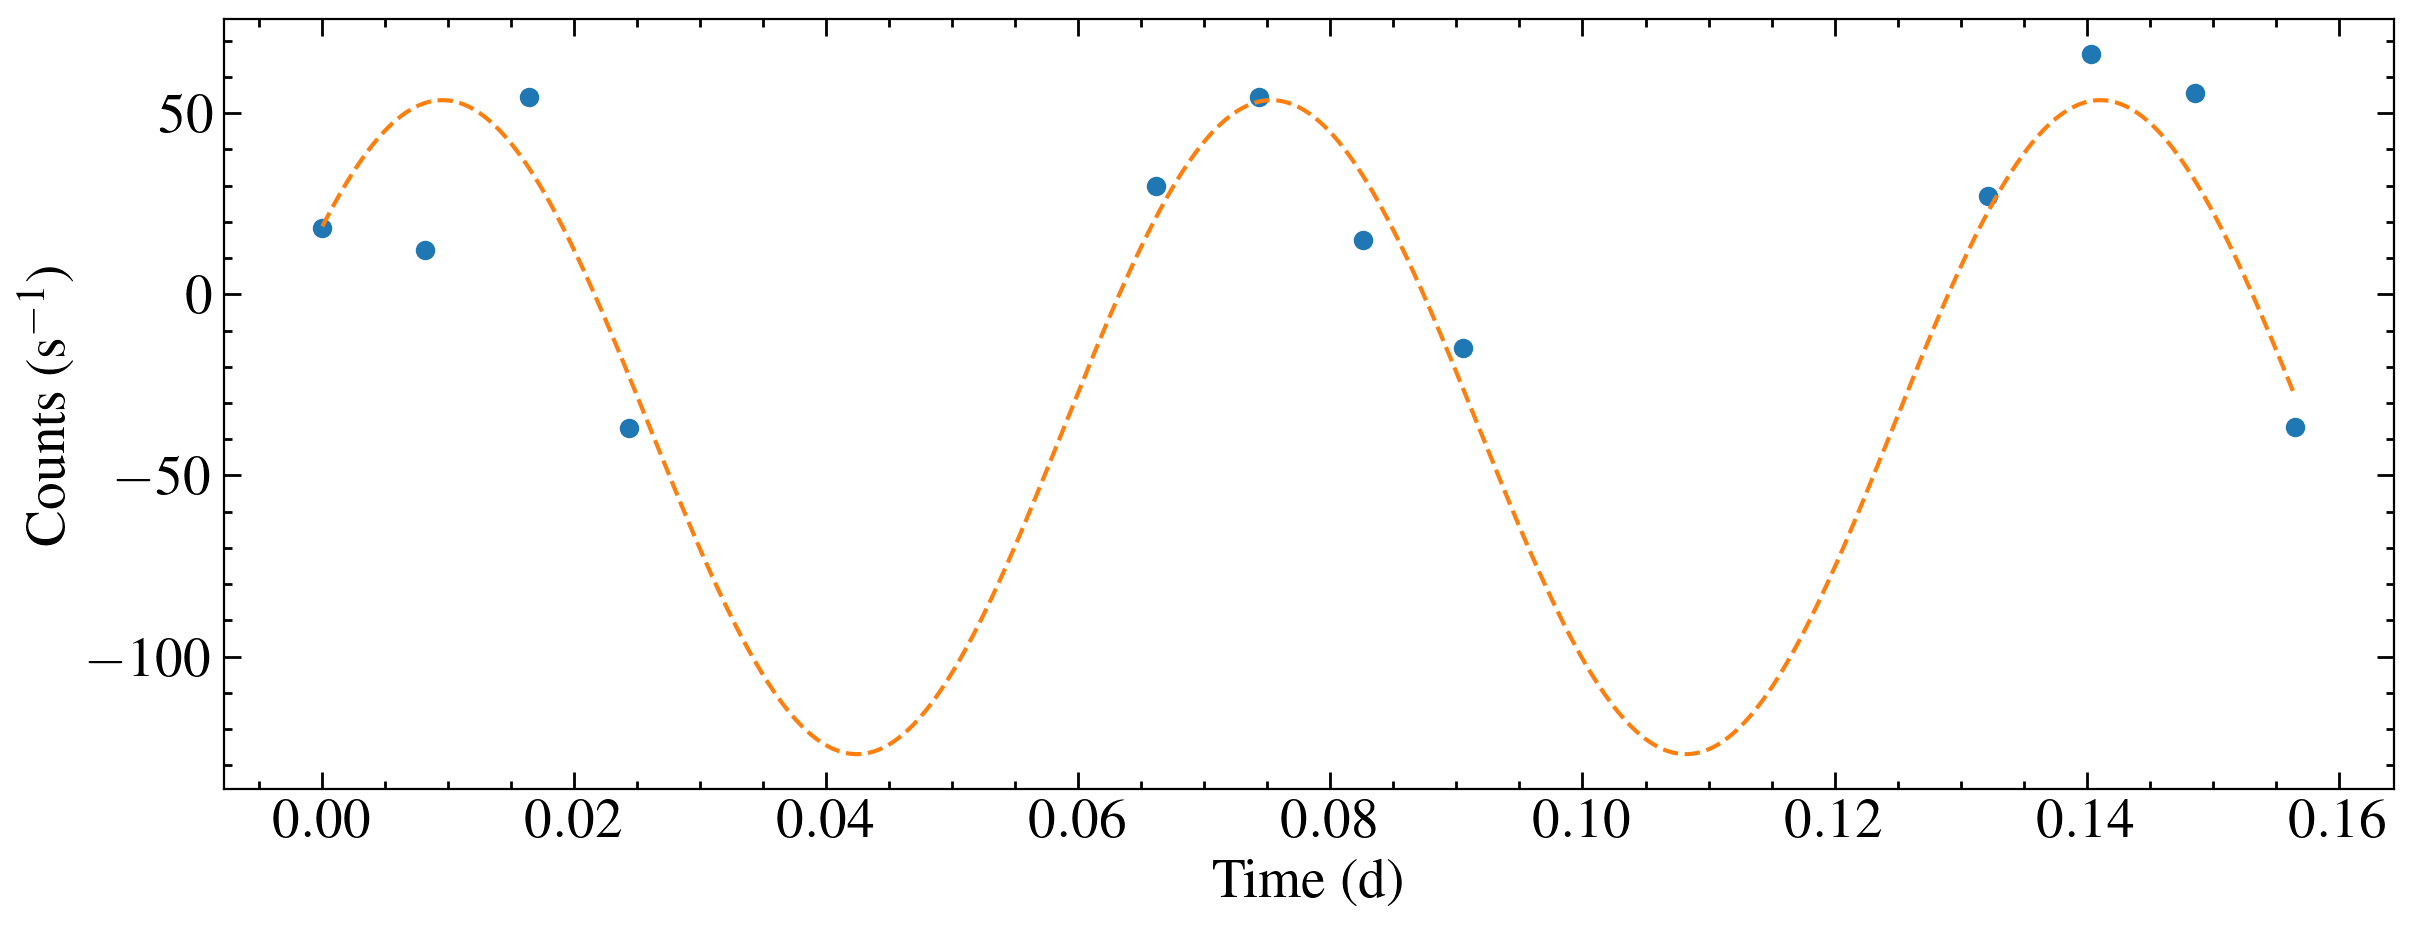

fitted orbit = 94.83007020360374 min
real orbit = 94.9917376076 min
difference =  -0.17048116029984559 %


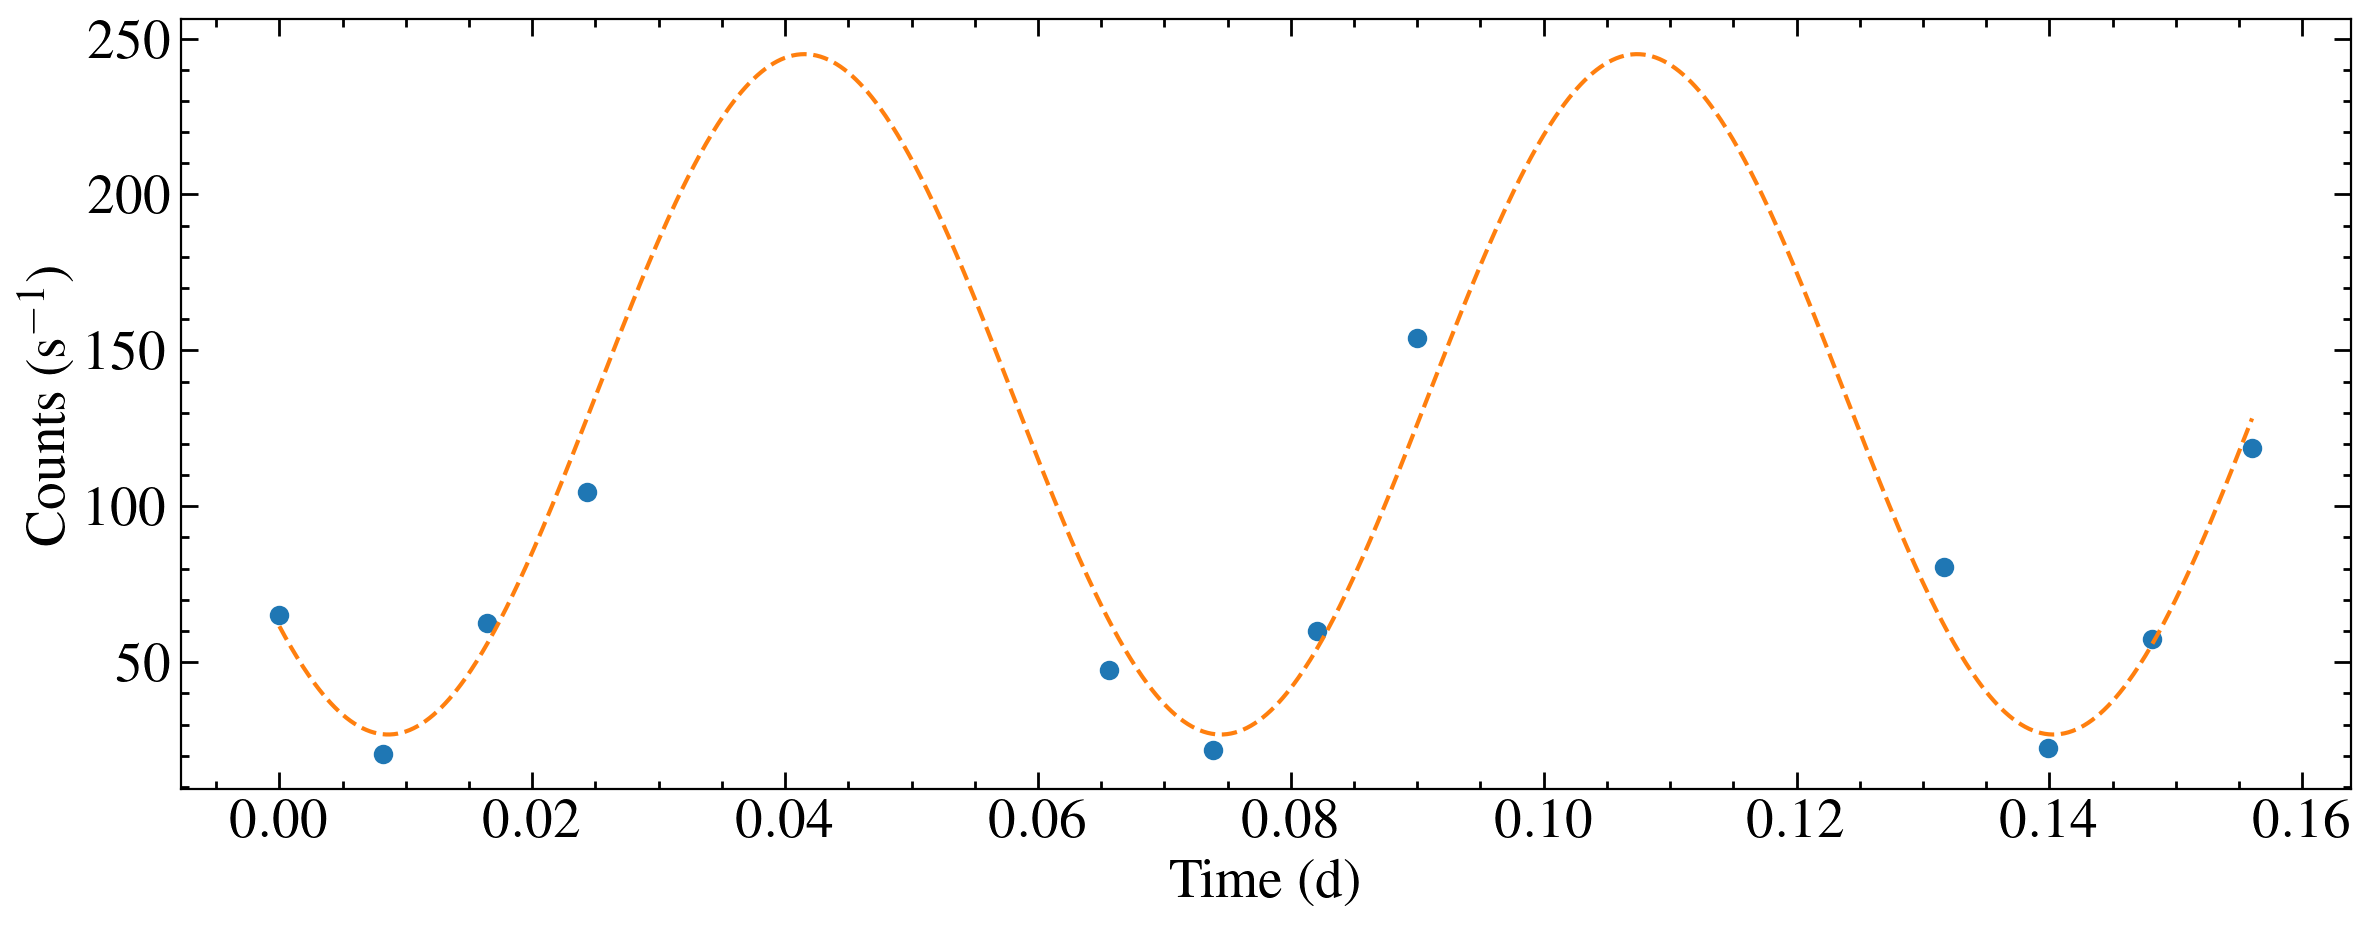

fitted orbit = 97.98040869634569 min
real orbit = 94.9917376076 min
difference =  3.050274160427294 %


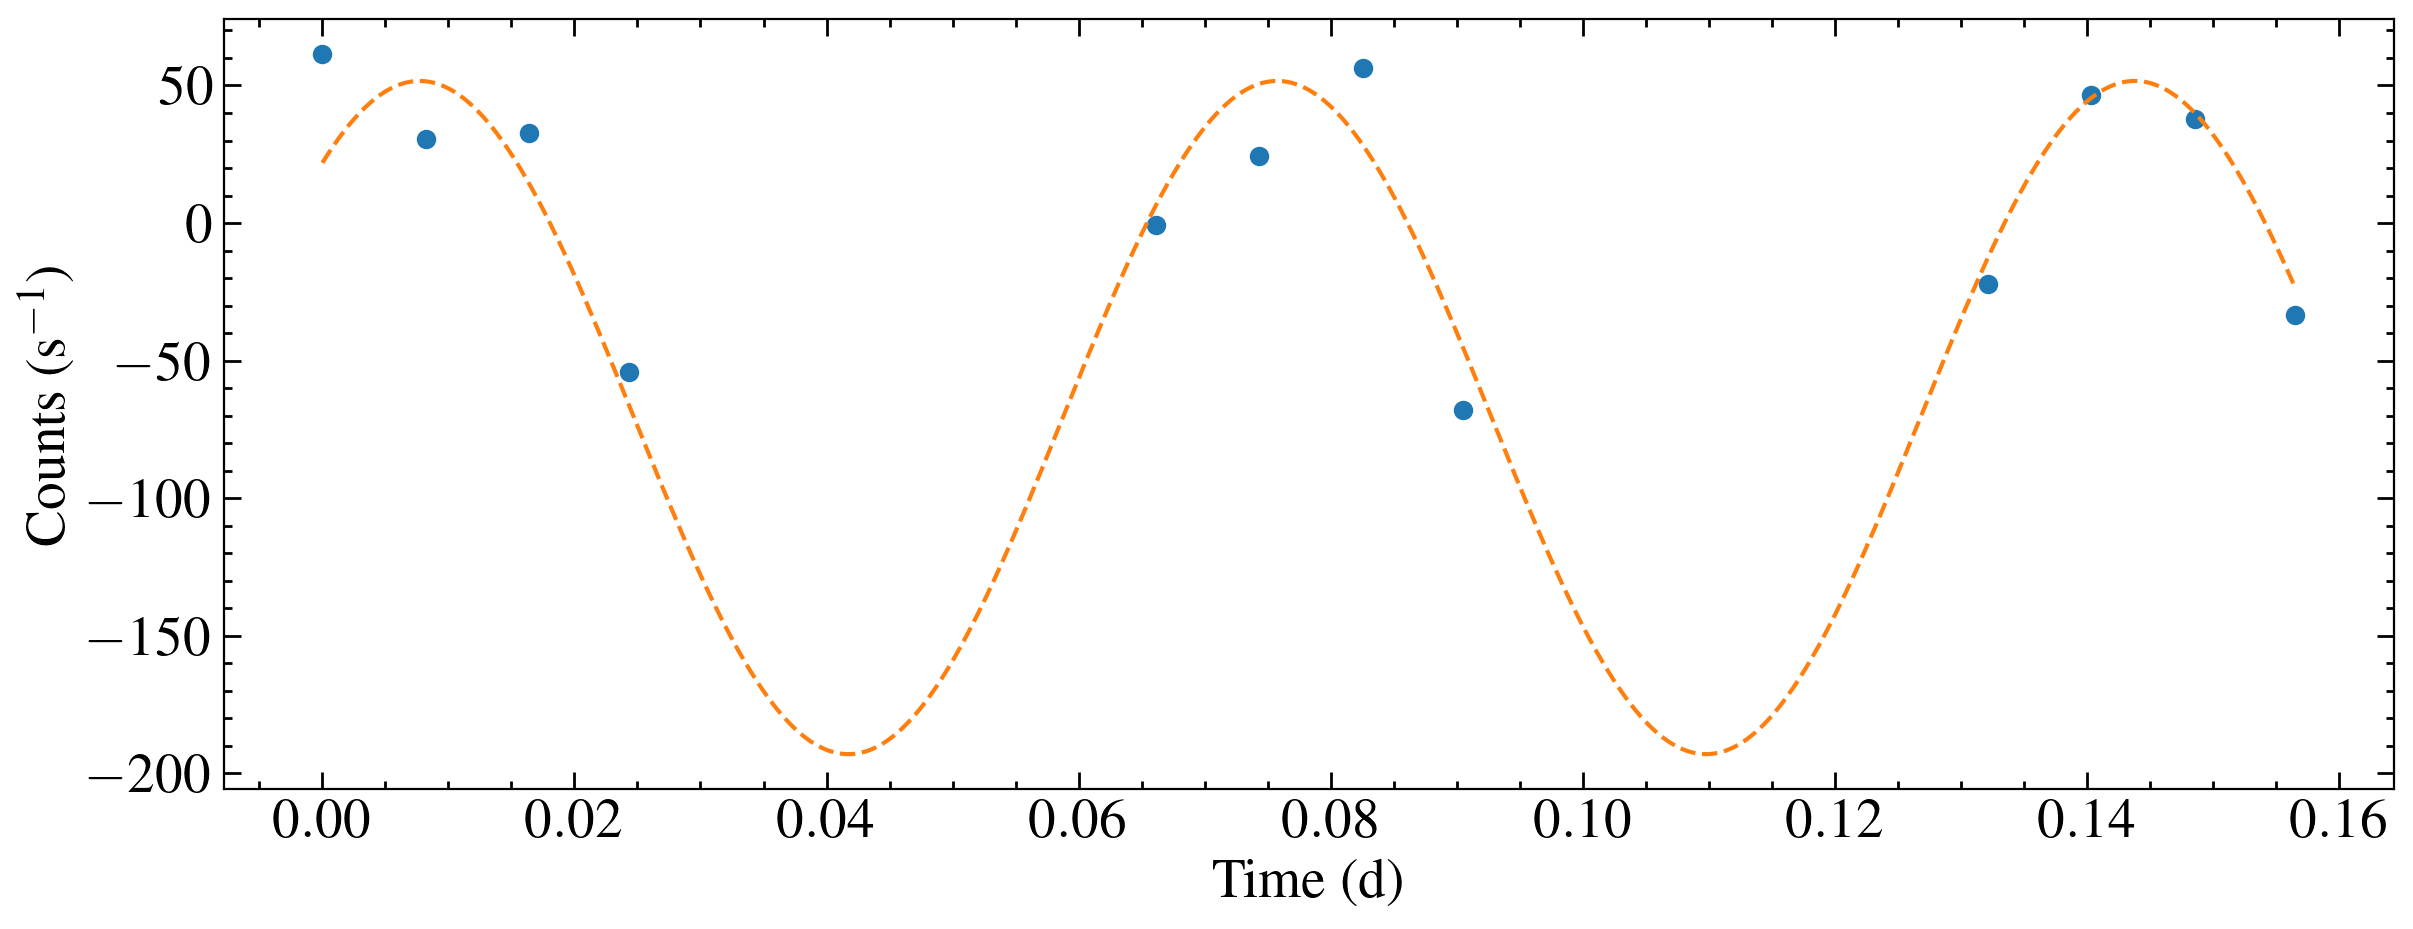

In [16]:


for i, phot in enumerate(wfc3):
#     print(phot)
    times = []
    bkg = []
    fig, ax = plt.subplots()

    data = Table.read(phot)
    for row in data:
        if row['FILTER'] == 'F280N':
            c = 'C0'
            m = 'o'
        elif row['FILTER'] == 'F275W':
            c = 'C1'
            m ='s'
        elif row['FILTER'] == 'F225W':
            c = 'C2'
            m ='p'

   
#         ax.errorbar(((row['EXPSTART']+row['EXPEND'])/2)+0.001, row['COUNTS']+row['BACKGROUND'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], 
#                     marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7, capsize=2)
#         ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['COUNTS'], yerr=row['COUNTS_ERROR'], label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         ax.errorbar((row['EXPSTART']+row['EXPEND'])/2, row['BACKGROUND'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
        times.append((row['EXPSTART']+row['EXPEND'])/2)
        bkg.append(row['BACKGROUND'][0])
    

    times = np.array(times) - min(times)

    plt.scatter(times, bkg)


    orb = ((90*u.min).to(u.d)).value
    mod = models.Const1D(100) + models.Sine1D(50, 1/orb)

    modfit = fitter(mod, times, bkg, maxiter=10000)

    timefit = np.linspace(min(times), max(times), 1000)
    plt.plot(timefit, modfit(timefit), ls='--', c='C1')
    # print((((1/modfit[1].frequency)*u.d).to(u.minute)))

    # print(modfit)

    hsthorb = 2.849752128228E+03 #from spt header
    # print(((hsthorb*2)*u.s).to(u.minute))

    myorb = ((1/modfit[1].frequency)*u.d).to(u.minute).value
    realorb = ((hsthorb*2)*u.s).to(u.minute).value
    ax.set_ylabel('Counts (s$^{-1}$)')
    ax.set_xlabel('Time (d)')

    print('fitted orbit =', myorb,'min')
    print('real orbit =', realorb, 'min')
    print('difference = ',((myorb-realorb)/myorb)*100, '%')
    plt.show()

How does the flux calibration change over time? Not at all.

In [17]:
f280n_phot = []
f280n_t  = []
f275w_phot = []
f275w_t  = []
f225w_phot = []
f225w_t  = []

for i in (1, 2, 3):
    flcs = glob.glob('/media/david/2tb_ext_hd/hddata/trappist-1_phot/epoch{}/wfc3/*flc.fits'.format(i))
    for flc in flcs:
        hdr = fits.getheader(flc,0)
        hdr1 = fits.getheader(flc,1)
        if hdr['FILTER'] == 'F280N':
            f280n_phot.append(hdr['PHOTFLAM'])
            f280n_t.append(hdr['EXPSTART'])
        
        if hdr['FILTER'] == 'F225W':
            f225w_phot.append(hdr['PHOTFLAM'])
            f225w_t.append(hdr['EXPSTART'])
        if hdr['FILTER'] == 'F275W':
            f275w_phot.append(hdr['PHOTFLAM'])
            f275w_t.append(hdr['EXPSTART'])
            
# plt.plot(f280n_t, f280n_phot)
# plt.show()
# plt.plot(f225w_t, f225w_phot)
# plt.show()

# plt.plot(f275w_t, f275w_phot)

print(min(f280n_phot)/max(f280n_phot))
print(min(f225w_phot)/max(f225w_phot))
print(min(f275w_phot)/max(f275w_phot))

0.9999235189049825
0.9999122502140647
0.9999252077260541


In [18]:
f280n_phot

[5.9173497e-17,
 5.9173517e-17,
 5.917353e-17,
 5.9175727e-17,
 5.9175753e-17,
 5.917574e-17,
 5.9177997e-17,
 5.917801e-17,
 5.9178023e-17]

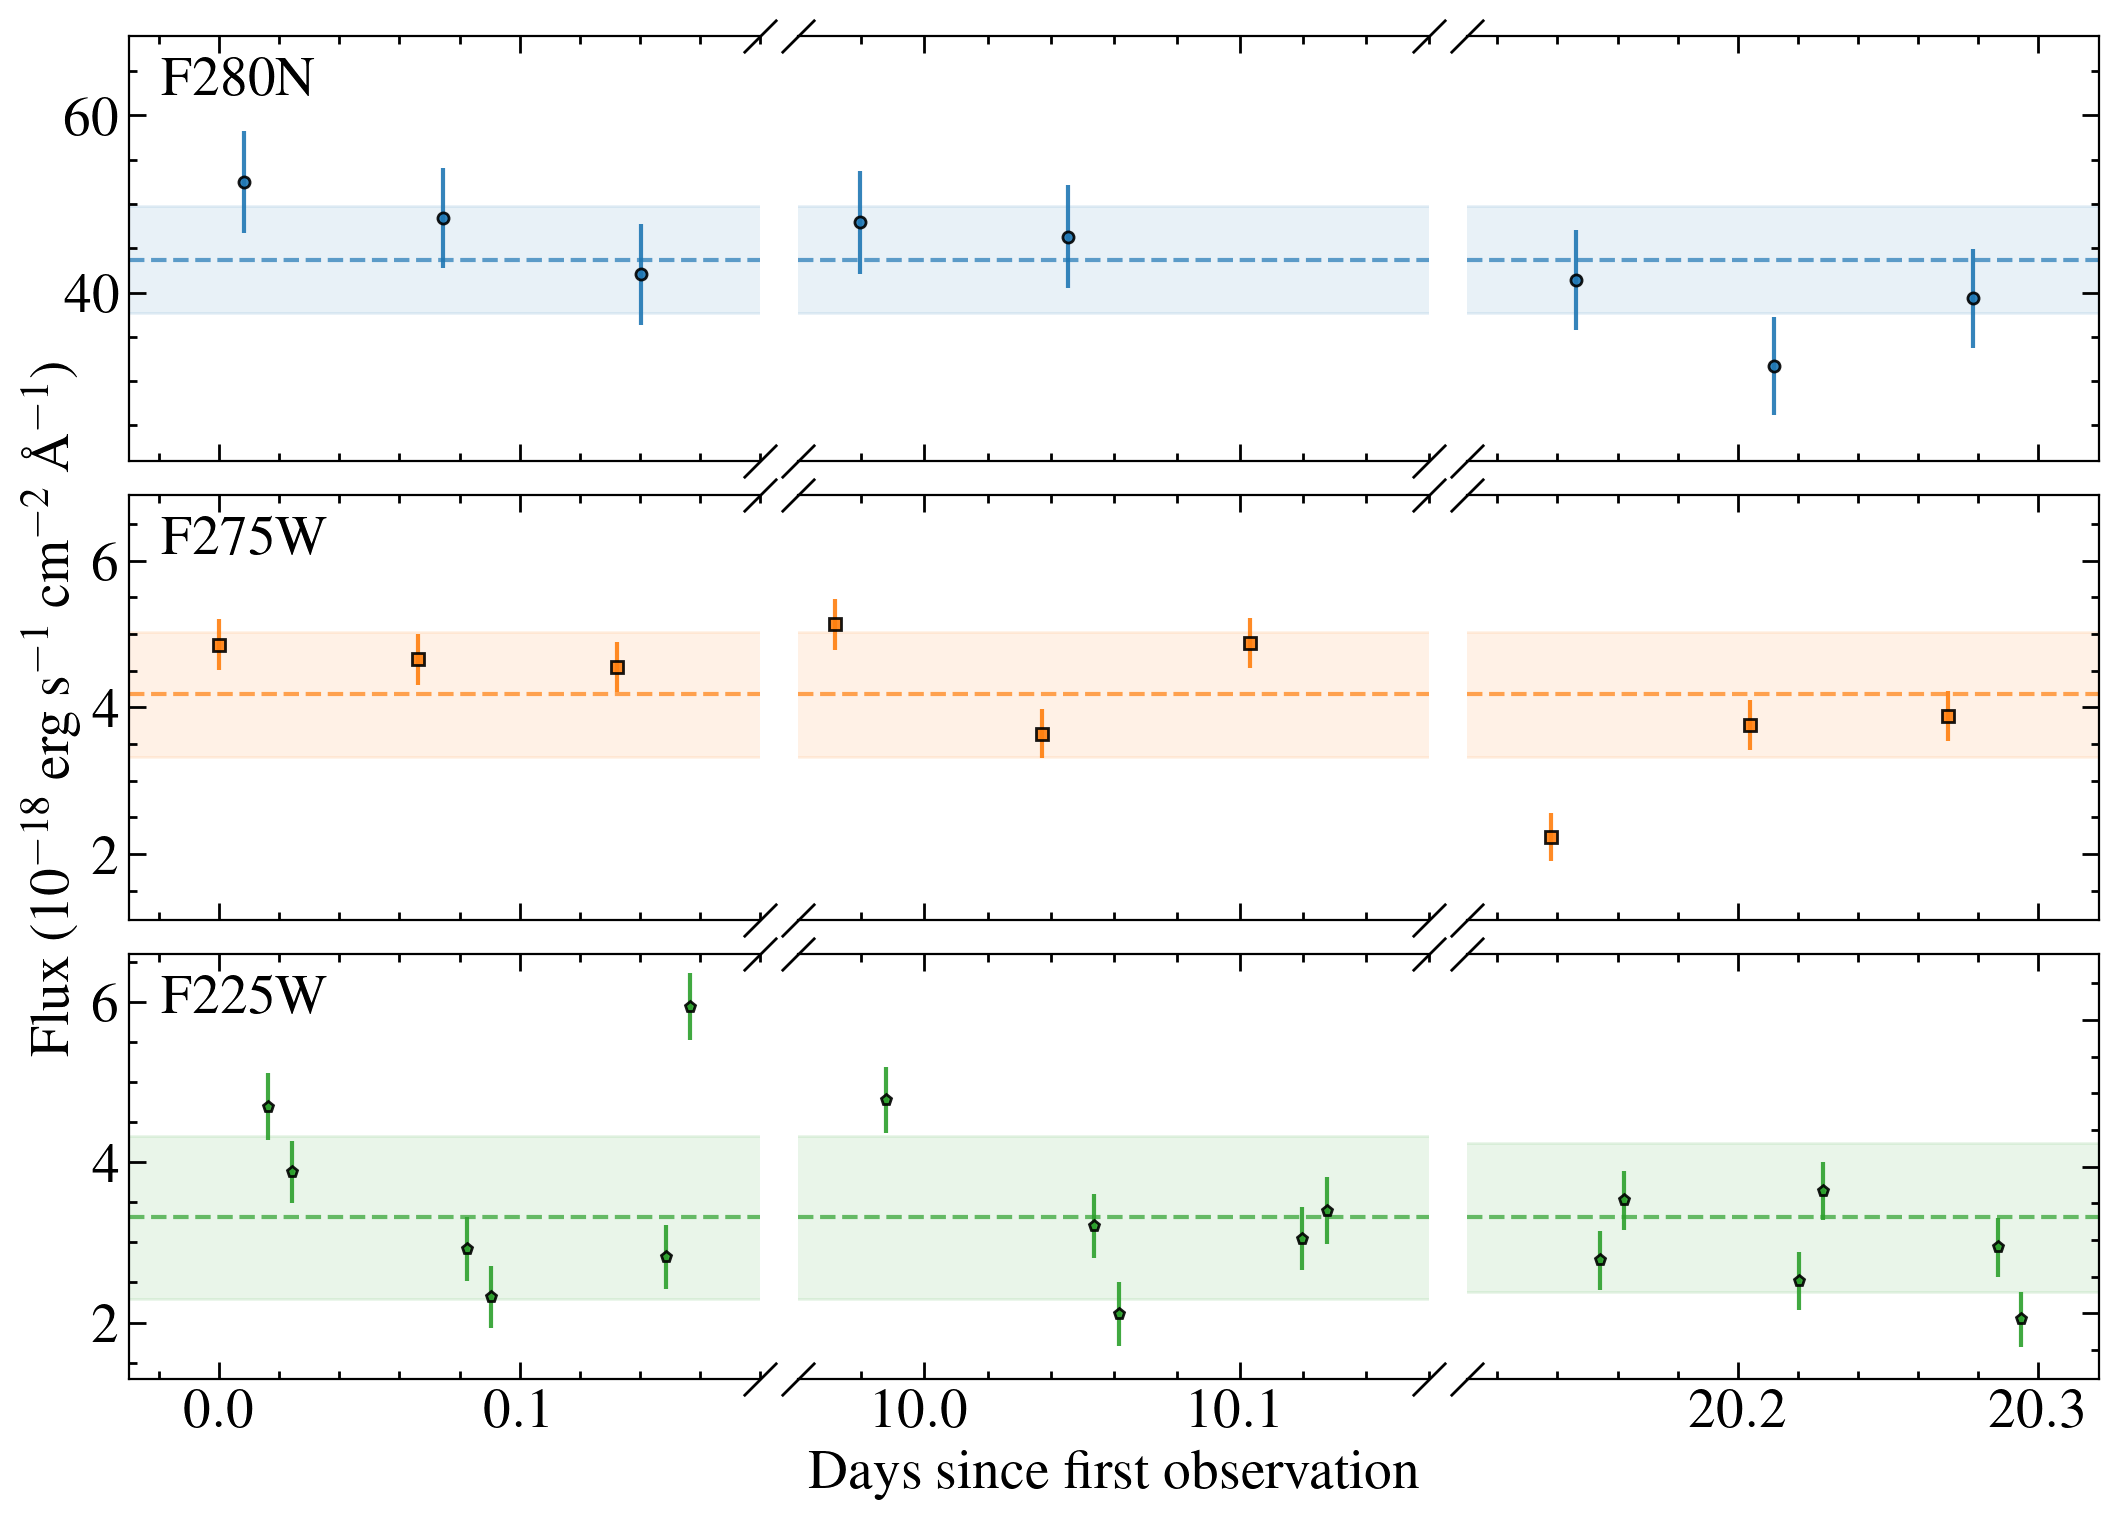

In [19]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

f280n = []
f275w = []
f225w= []

# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, ax= plt.subplots(ncols=3, nrows=3, figsize=(11, 8))#, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax[0, 0].set_xlim(-0.03, 0.18) 
ax[0, 1].set_xlim(9.96, 10.16)  
ax[0, 2].set_xlim(20.11, 20.32)  
ax[1, 0].set_xlim(-0.03, 0.18) 
ax[1, 1].set_xlim(9.96, 10.16)  
ax[1, 2].set_xlim(20.11, 20.32)  
ax[2, 0].set_xlim(-0.03, 0.18) 
ax[2, 1].set_xlim(9.96, 10.16)  
ax[2, 2].set_xlim(20.11, 20.32)  


ax[0, 0].set_ylim(21, 69)
ax[0, 1].set_ylim(21, 69)
ax[0, 2].set_ylim(21, 69)
ax[1, 0].set_ylim(1.1, 6.9)
ax[1, 1].set_ylim(1.1, 6.9)
ax[1, 2].set_ylim(1.1, 6.9)
ax[1, 0].set_ylim(1.1, 6.9)
ax[1, 1].set_ylim(1.1, 6.9)
ax[2, 2].set_ylim(1.1, 6.9)

# # hide the spines between ax and ax2
ax[0,0].spines.right.set_visible(False)
ax[1,0].spines.right.set_visible(False)
ax[2,0].spines.right.set_visible(False)
ax[0,0].yaxis.tick_left()
ax[1,0].yaxis.tick_left()
ax[2,0].yaxis.tick_left()

ax[0,1].spines.right.set_visible(False)
ax[0,1].spines.left.set_visible(False)
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.left.set_visible(False)
ax[0,1].tick_params(right = False, left=False, which='both')
ax[1,1].tick_params(right = False, left=False, which='both')
ax[2,1].tick_params(right = False, left=False, which='both')
ax[0, 1].yaxis.set_tick_params(labelleft=False)
ax[1, 1].yaxis.set_tick_params(labelleft=False)
ax[2, 1].yaxis.set_tick_params(labelleft=False)


ax[0,2].spines.left.set_visible(False)
ax[0,2].yaxis.tick_right()
ax[1,2].spines.left.set_visible(False)
ax[1,2].yaxis.tick_right()
ax[2,2].spines.left.set_visible(False)
ax[2,2].yaxis.tick_right()
ax[0, 2].yaxis.set_tick_params(labelright=False)
ax[1, 2].yaxis.set_tick_params(labelright=False)
ax[2, 2].yaxis.set_tick_params(labelright=False)


ax[0, 0].xaxis.set_tick_params(labelbottom=False)
ax[0, 1].xaxis.set_tick_params(labelbottom=False)
ax[0, 2].xaxis.set_tick_params(labelbottom=False)
ax[1, 0].xaxis.set_tick_params(labelbottom=False)
ax[1, 1].xaxis.set_tick_params(labelbottom=False)
ax[1, 2].xaxis.set_tick_params(labelbottom=False)



# # Now, let's turn towards the cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the axes.
# # The slanted lines themselves are markers at those locations, such that the
# # lines keep their angle and position, independent of the axes size or scale
# # Finally, we need to disable clipping.

d = 1.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0,0].plot([1, 1], [0, 1], transform=ax[0,0].transAxes, **kwargs)
ax[0,1].plot([0, 1], [1, 1], transform=ax[0,1].transAxes, **kwargs)
ax[0,1].plot([0, 1], [0, 0], transform=ax[0, 1].transAxes, **kwargs)
ax[0,2].plot([0, 0], [1, 0], transform=ax[0,2].transAxes, **kwargs)

ax[1,0].plot([1, 1], [0, 1], transform=ax[1,0].transAxes, **kwargs)
ax[1,1].plot([0, 1], [1, 1], transform=ax[1,1].transAxes, **kwargs)
ax[1,1].plot([0, 1], [0, 0], transform=ax[1, 1].transAxes, **kwargs)
ax[1,2].plot([0, 0], [1, 0], transform=ax[1,2].transAxes, **kwargs)

ax[2,0].plot([1, 1], [0, 1], transform=ax[2,0].transAxes, **kwargs)
ax[2,1].plot([0, 1], [1, 1], transform=ax[2,1].transAxes, **kwargs)
ax[2,1].plot([0, 1], [0, 0], transform=ax[2, 1].transAxes, **kwargs)
ax[2,2].plot([0, 0], [1, 0], transform=ax[2,2].transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                r = 0
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                r = 1
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                r = 2
            ax[r, 0].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 1].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 2].errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)



#             if row['FILTER'] == 'F280N':
            

            
#             else:
#                 ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

# x = np.arange(-5, 30)
ax[0, 0].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,0].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 1].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,1].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 2].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,2].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)



ax[1, 0].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 0].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 1].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 1].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 2].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 2].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)

ax[2, 0].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 0].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 1].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 1].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 2].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 2].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)


    
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax[1, 0].set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[2, 1].set_xlabel('Days since first observation')
ax[0,0].annotate('F280N', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
ax[1,0].annotate('F275W', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
ax[2,0].annotate('F225W', (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')


fig.tight_layout()
fig.subplots_adjust(wspace=0.06, hspace=0.08)  # adjust space between axes



# plt.show()

plt.savefig('plots/t1_seperate_lcs.pdf')


In [20]:
f280n = []
f275w = []
f225w= []
f280n_e = []
f275w_e = []
f225w_e= []


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                f225w.append(row['FLUX'])                
                f225w_e.append(row['ERROR'])

f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e) 
    
print('F280N')
print(f280n/f280n_e)
print(np.mean(f280n/f280n_e), np.median(f280n/f280n_e), np.std(f280n/f280n_e))

print('F275W')
print(f275w/f275w_e)
print(np.mean(f275w/f275w_e), np.median(f275w/f275w_e), np.std(f275w/f275w_e))

print('F225W')
print(f225w/f225w_e)
print(np.mean(f225w/f225w_e), np.median(f225w/f225w_e), np.std(f225w/f225w_e))

F280N
[9.14418742 8.55766444 7.3628469  8.24466389 7.94380552 7.31336112
 5.723755   7.03972321]
7.666250937749035 7.653326206601205 0.9857056534974088
F275W
[14.0312499  13.31845758 13.15677848 14.76643432 10.90572431 14.29642339
  6.80489949 11.22547848 11.52817312]
12.225957674178588 13.15677847706173 2.3256698720707645
F225W
[11.24585223 10.05085172  7.31680938  5.99192474  7.0766953  14.23988571
 11.51194646  7.99909103  5.27685515  7.73512235  8.18557964  6.75943478
  8.90299388  6.14533396  9.28452786  7.22908732  5.04263944]
8.234978290783536 7.735122350873731 2.360571356819626


In [21]:
# 5.93668747e-18 4.16905556e-19
print(f225w)
print(f225w_e)
mask = (f225w < 5.5e-18)

print(np.mean(f225w))
print(np.mean(f225w[mask]))
print(np.std(f225w))
print(np.std(f225w[mask]))

print((5.93668747e-18-np.mean(f225w[mask]))/np.std(f225w[mask]))

print((5.93668747e-18-2.82143790e-18)/4.16905556e-19)

print(f275w)

[4.69310477e-18 3.88067809e-18 2.92268963e-18 2.31512167e-18
 2.82143790e-18 5.93668747e-18 4.77566797e-18 3.20285476e-18
 2.11109319e-18 3.04757464e-18 3.39642084e-18 2.72078217e-18
 3.53762644e-18 2.43270975e-18 3.66629328e-18 2.89837741e-18
 1.91557167e-18]
[4.17318730e-19 3.86104402e-19 3.99448650e-19 3.86373622e-19
 3.98694275e-19 4.16905556e-19 4.14844526e-19 4.00402339e-19
 4.00066543e-19 3.93991783e-19 4.14927347e-19 4.02516225e-19
 3.97352451e-19 3.95862904e-19 3.94882038e-19 4.00932688e-19
 3.79874804e-19]
3.3102759793837306e-18
3.146125261118101e-18
1.0174777678184337e-18
8.011816459355579e-19
3.4830580843165673
7.47231483285869
[4.85650453e-18 4.65488424e-18 4.54961383e-18 5.13228303e-18
 3.64262342e-18 4.88106028e-18 2.23367932e-18 3.75975525e-18
 3.88544057e-18]


In [22]:
3.8/2.2

1.727272727272727

4.7625748853059357e-17 4.687123024201185e-18 3.702870943117048e-18 3.291278334269941e-18 2.0041570552963399e-19 1.7036965804715411e-19
4.709977014621346e-17 4.5316798905666145e-18 3.282795214017994e-18 4.114500703837729e-18 1.9679684412744362e-19 1.855241119922278e-19
3.742078227266277e-17 3.2761282890842853e-18 2.8488357373977445e-18 3.231238607826323e-18 1.9245466760523983e-19 1.643265608372743e-19


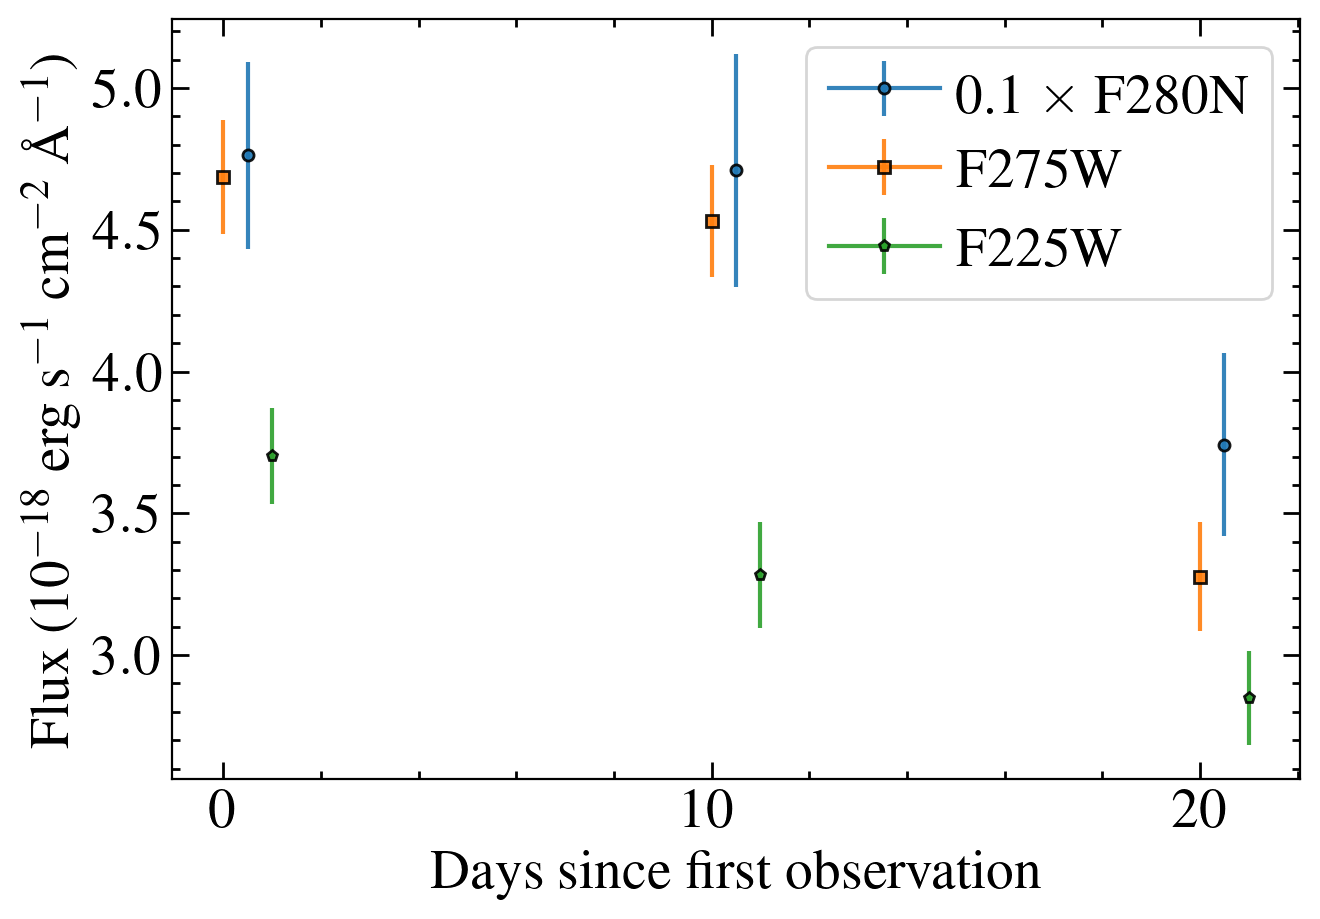

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

# cols = [0, 1, 2]

for i, phot in enumerate(wfc3):
    data = Table.read(phot)
    
    f280n = []
    f275w = []
    f225w= []
    f280n_e = []
    f275w_e = []
    f225w_e= []
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                f280n_e.append(row['ERROR'])
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                f275w_e.append(row['ERROR'])
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                f225w_e.append(row['ERROR'])

    f280n ,f275w, f225w,f280n_e, f275w_e, f225w_e = np.array(f280n) ,np.array(f275w), np.array(f225w),np.array(f280n_e), np.array(f275w_e), np.array(f225w_e) 
    
    f280n_av = np.average(f280n, weights = 1/(f280n_e**2))
    f280n_ave = (1/(np.sum(1/(f280n_e**2))))**0.5
    ax.errorbar(days[i]+0.5, f280n_av*scale/10, yerr=f280n_ave*scale/10, marker='o', c='C0', label = r'0.1 $\times$ F280N',  markeredgecolor='k', markersize=4, alpha=0.9)
        
#     if i == 2:
#         f275w_av = np.average(f275w[1:], weights = 1/(f275w_e[1:]**2))
#         f275w_ave = (1/(np.sum(1/(f275w_e[1:]**2))))**0.5
    
#     else:
    f275w_av = np.average(f275w, weights = 1/(f275w_e**2))
    f275w_ave = (1/(np.sum(1/(f275w_e**2))))**0.5
    ax.errorbar(days[i], f275w_av*scale, yerr=f275w_ave*scale, marker='s', c='C1', label='F275W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    f225w_av = np.average(f225w, weights = 1/(f225w_e**2))
    f225w_e = np.full(len(f225w), f225w_e[0])
    f225w_ave = (1/(np.sum(1/(f225w_e**2))))**0.5
    ax.errorbar(days[i]+1, f225w_av*scale, yerr=f225w_ave*scale, marker='p', c='C2', label = 'F225W',  markeredgecolor='k', markersize=4, alpha=0.9)
    
    print(f280n_av ,f275w_av, f225w_av,f280n_ave, f275w_ave, f225w_ave)
    
#     print(f280n_av/f275w_av)
#     print(f280n_av/f225w_av)

            
        
            
#         if row['FILTER'] == 'F280N':
#             ax.errorbar(days[i], row['FLUX']*scale/10, yerr=row['ERROR']*scale/10, label = '0.1 x {}'.format(row['FILTER']), 
#                         marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)
#         else:
#             ax.errorbar(days[i], row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.7)




# ax.axhline(np.mean(f280n)*scale/10, ls ='--', alpha=0.5, c='C0')
# ax.axhline(np.mean(f275w)*scale, ls ='--', alpha=0.5, c='C1')
# ax.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.5, c='C2')
        
# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since first observation')
ax.set_xticks(days)

# ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

fig.tight_layout()
fig.savefig('plots/wfc3_average_visits.pdf')

In [24]:
3.742078227266277e-17/4.7625748853059357e-17

0.7857258557365225

In [25]:
3.2761282890842853e-18/4.687123024201185e-18

0.6989635800401522

In [26]:
2.8488357373977445e-18/3.702870943117048e-18

0.7693586358155968

Urg should look at ACS to add to the big plot

In [27]:
acs = glob.glob('results/*acs*')
acs.sort()
acs

['results/epoch1_acs_photometry.ecsv',
 'results/epoch2_acs_photometry.ecsv',
 'results/epoch3_acs_photometry.ecsv']

[0.91030443 0.40407749 0.85708859]
[0.31817901 0.55522055 0.43810211]


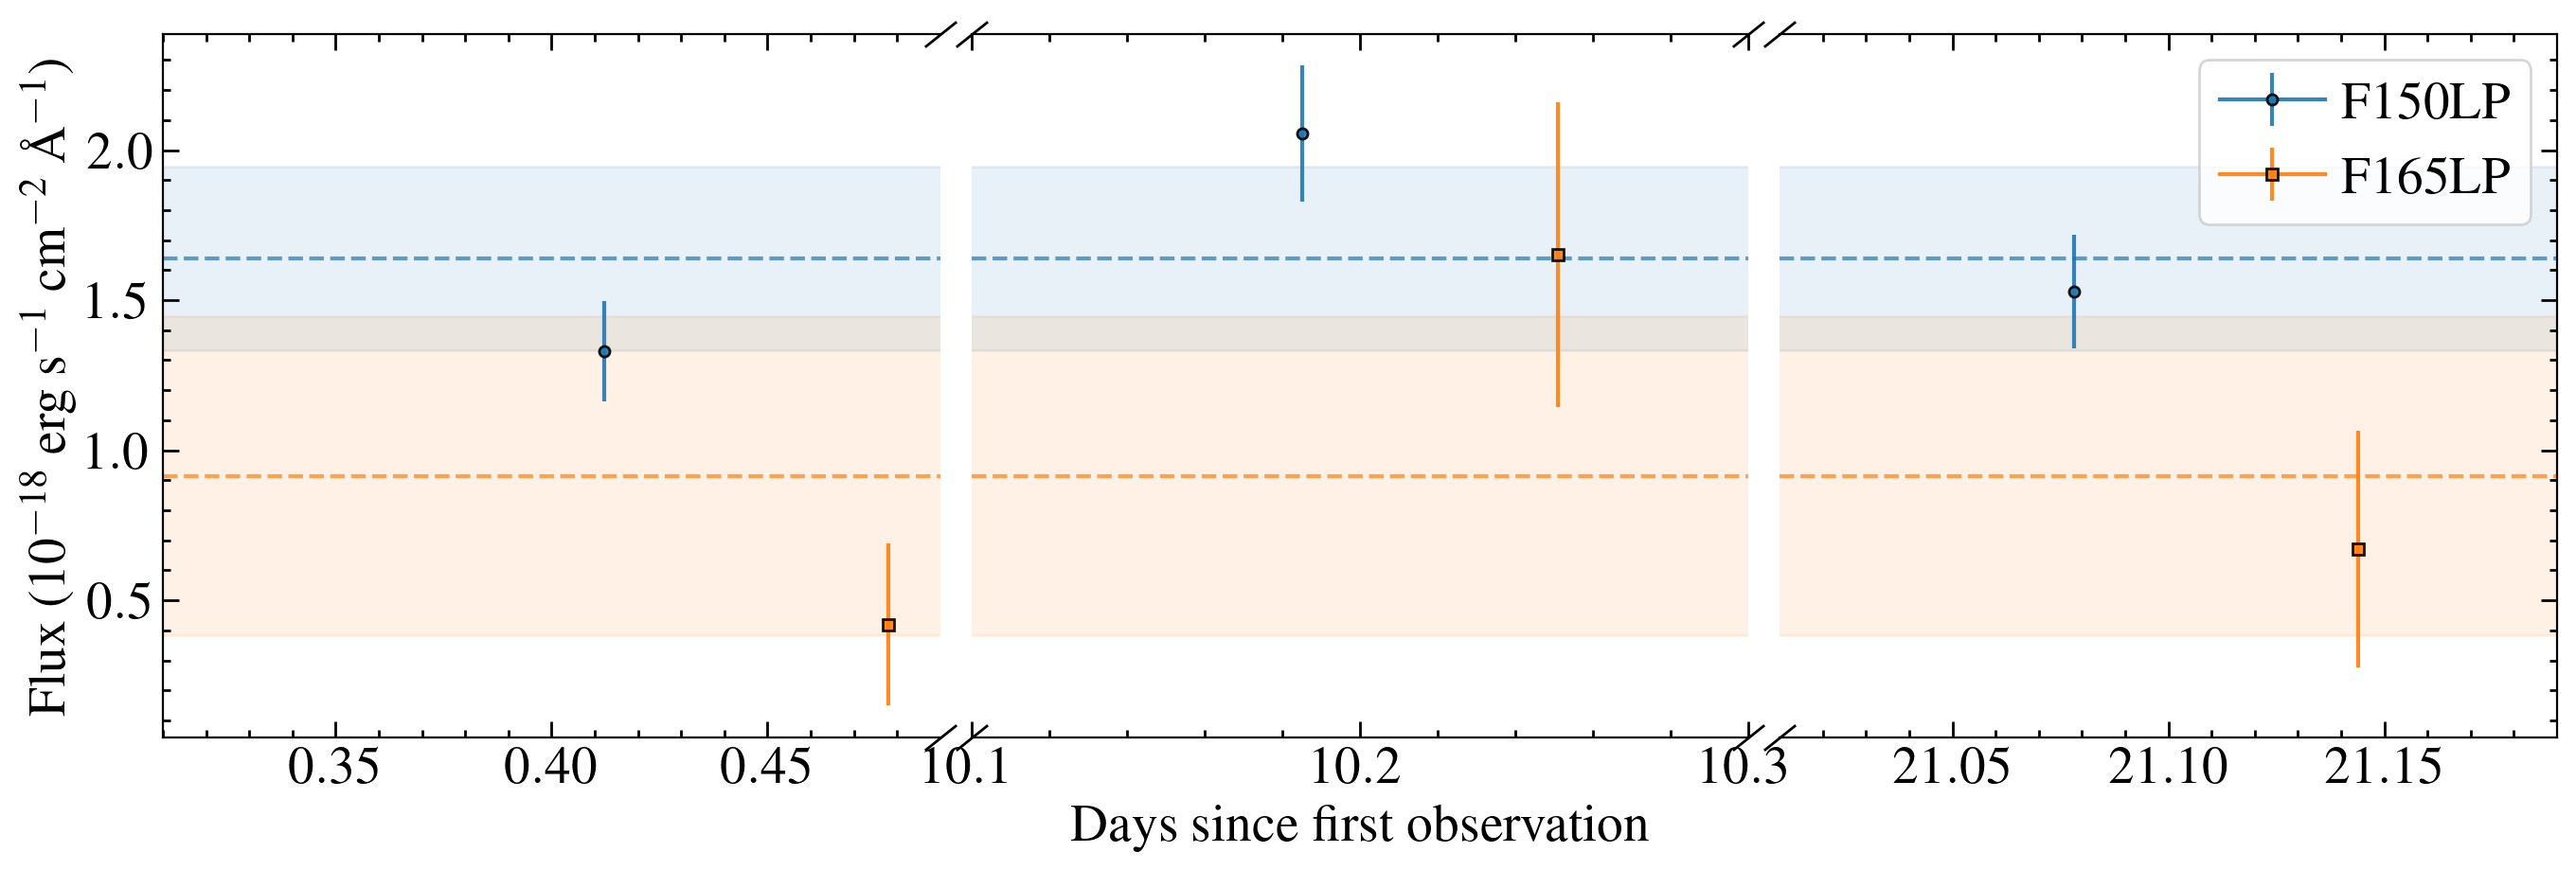

In [28]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

f150lp = []
f150lp_e = []
f165lp = []
f165lp_e = []


# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax1.set_xlim(0.31, 0.49) 
ax2.set_xlim(10.1, 10.3)  
ax3.set_xlim(21.01, 21.19)  

# ax1.set_ylim(1.1, 6.9)

# hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
ax1.spines.right.set_visible(False)
ax1.yaxis.tick_left()

ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
# ax2.tick_params(labelright=False)
# ax2.yaxis.tick_left()
# ax2.yaxis.tick_right()
# ax2.tick_params(labelcolor='none', left=False, right=False, which='both')
ax2.tick_params(right = False, left=False, which='both')
# ax2.set_yticks([])

ax3.spines.left.set_visible(False)
ax3.yaxis.tick_right()
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()

# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']


for i, phot in enumerate(acs):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F150LP':
                c = 'C0'
                m = 'o'
                f150lp.append(row['FLUX'])
                f150lp_e.append(row['ERROR'])
            elif row['FILTER'] == 'F165LP':
                c = 'C1'
                m ='s'
                f165lp.append(row['FLUX'])
                f165lp_e.append(row['ERROR'])
         


            ax1.errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax2.errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax3.errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

x = np.arange(-5, 30)
ax1.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
ax1.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')
# ax1.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
ax1.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
ax1.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)


ax2.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
ax2.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')
ax2.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
ax2.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)

ax3.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
ax3.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')  
ax3.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
ax3.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)
# # ax.set_yscale('log')
# ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax.set_xlabel('Days since 1st observation')
# ax.set_xticks(days)

# # ax.set_xlim(-4, 49)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax1.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax2.set_xlabel('Days since first observation')

fig.tight_layout()
fig.subplots_adjust(wspace=0.04)  # adjust space between axes


f150lp, f150lp_e, f165lp, f165lp_e = np.array(f150lp), np.array(f150lp_e), np.array(f165lp), np.array(f165lp_e)

print((f150lp - f165lp)*1e18)
print(((f150lp_e**2+f165lp_e**2)**0.5)*1e18)

fdiff = f150lp - f165lp
fdiff_e = ((f150lp_e**2+f165lp_e**2)**0.5)
# plt.show()

# plt.savefig('plots/t1_flcs_lc.pdf')


In [29]:
# # fig, ax = plt.subplots(figsize=(6, 6))
# # scale = 1e18

# # #2023-06-20, 2023-06-30, 2023-07-10 
# # days = [0, 10, 20]
# # # cols = [0, 1, 2]



# # fig.tight_layout()
# # fig.savefig('plots/wfc3_all_visits.pdf')

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# # plot the same data on both axes
# # ax1.plot(pts)
# # ax2.plot(pts)

# ax1.set_xlim(-0.4, 0.4) 
# ax2.set_xlim(9.6, 10.4)  
# ax3.set_xlim(19.0, 20.1)  

# # ax1.set_ylim(1.1, 6.9)

# # hide the spines between ax and ax2
# # ax1.spines.bottom.set_visible(False)
# ax1.spines.right.set_visible(False)
# ax1.yaxis.tick_left()

# ax2.spines.right.set_visible(False)
# ax2.spines.left.set_visible(False)
# # ax2.tick_params(labelright=False)
# # ax2.yaxis.tick_left()
# # ax2.yaxis.tick_right()
# # ax2.tick_params(labelcolor='none', left=False, right=False, which='both')
# ax2.tick_params(right = False, left=False, which='both')
# # ax2.set_yticks([])

# ax3.spines.left.set_visible(False)
# ax3.yaxis.tick_right()
# # ax2.spines.top.set_visible(False)
# # ax1.xaxis.tick_top()

# # ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# # ax2.xaxis.tick_bottom()

# # Now, let's turn towards the cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the axes.
# # The slanted lines themselves are markers at those locations, such that the
# # lines keep their angle and position, independent of the axes size or scale
# # Finally, we need to disable clipping.

# d = .8  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
# ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)


# # days2 = (0.5, 11, 21)


# ax1.errorbar(days, fdiff*scale, yerr=fdiff_e*scale, label = 'F150LP - F165LP', marker=m, c='C0', markeredgecolor='k', markersize=4, alpha=0.9, ls='none')
# ax2.errorbar(days, fdiff*scale, yerr=fdiff_e*scale, label = 'F150LP - F165LP', marker=m, c='C0', markeredgecolor='k', markersize=4, alpha=0.9, ls='none')
# ax3.errorbar(days, fdiff*scale, yerr=fdiff_e*scale, label = 'F150LP - F165LP', marker=m, c='C0', markeredgecolor='k', markersize=4, alpha=0.9, ls='none')

# # x = np.arange(-5, 30)
# # ax1.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
# # ax1.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')
# # # ax1.axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')
# # ax1.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
# # ax1.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)


# # ax2.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
# # ax2.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')
# # ax2.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
# # ax2.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)

# # ax3.axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C0')
# # ax3.axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C1')  
# # ax3.fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C0', alpha=0.1)
# # ax3.fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C1', alpha=0.1)
# # # # ax.set_yscale('log')
# # # ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # # ax.set_xlabel('Days since 1st observation')
# # # ax.set_xticks(days)

# # # # ax.set_xlim(-4, 49)
# # # ax.set_ylim(2.1, 7.9)

    

# ax1.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax2.set_xlabel('Days since first observation')

# ax1.axhline(0, ls = '--', c='0.5')
# ax2.axhline(0, ls = '--', c='0.5')
# ax3.axhline(0, ls = '--', c='0.5')

# simphot, simphot_e = 9.459369456324885e-19,5.708173610402945e-20


# ax1.axhline(simphot*scale, ls = '--', c='C2')
# ax2.axhline(simphot*scale, ls = '--', c='C2')
# ax3.axhline(simphot*scale, ls = '--', c='C2', label = r'C\,IV COS Model')
# ax1.fill_between(x, (simphot-simphot_e)*scale, (simphot+simphot_e)*scale , color='C2', alpha=0.1)
# ax2.fill_between(x, (simphot-simphot_e)*scale, (simphot+simphot_e)*scale , color='C2', alpha=0.1)
# ax3.fill_between(x, (simphot-simphot_e)*scale, (simphot+simphot_e)*scale , color='C2', alpha=0.1)


# print(fdiff/fdiff_e)

 
# fdiff_av = np.average(fdiff, weights = 1/(fdiff_e**2))
# fdiff_ave = (1/(np.sum(1/(fdiff_e**2))))**0.5
# ax2.errorbar(10.1, fdiff_av*scale, yerr=fdiff_ave*scale, c='C1', marker='o', markeredgecolor='k')
# ax3.errorbar(30.1, fdiff_av*scale, yerr=fdiff_ave*scale, c='C1', marker='o', markeredgecolor='k', label = 'Combined ACS Flux')


# print(fdiff_av, fdiff_ave)
# print(fdiff_av/fdiff_ave)

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=4) 


# fig.tight_layout()
# fig.subplots_adjust(wspace=0.04)  # adjust space between axes


# # plt.savefig('plots/t1_flcs_lc.pdf')



In [30]:
abands= glob.glob('filters/*ACS*')
abands

['filters/HST_ACS_SBC.F150LP.dat', 'filters/HST_ACS_SBC.F165LP.dat']

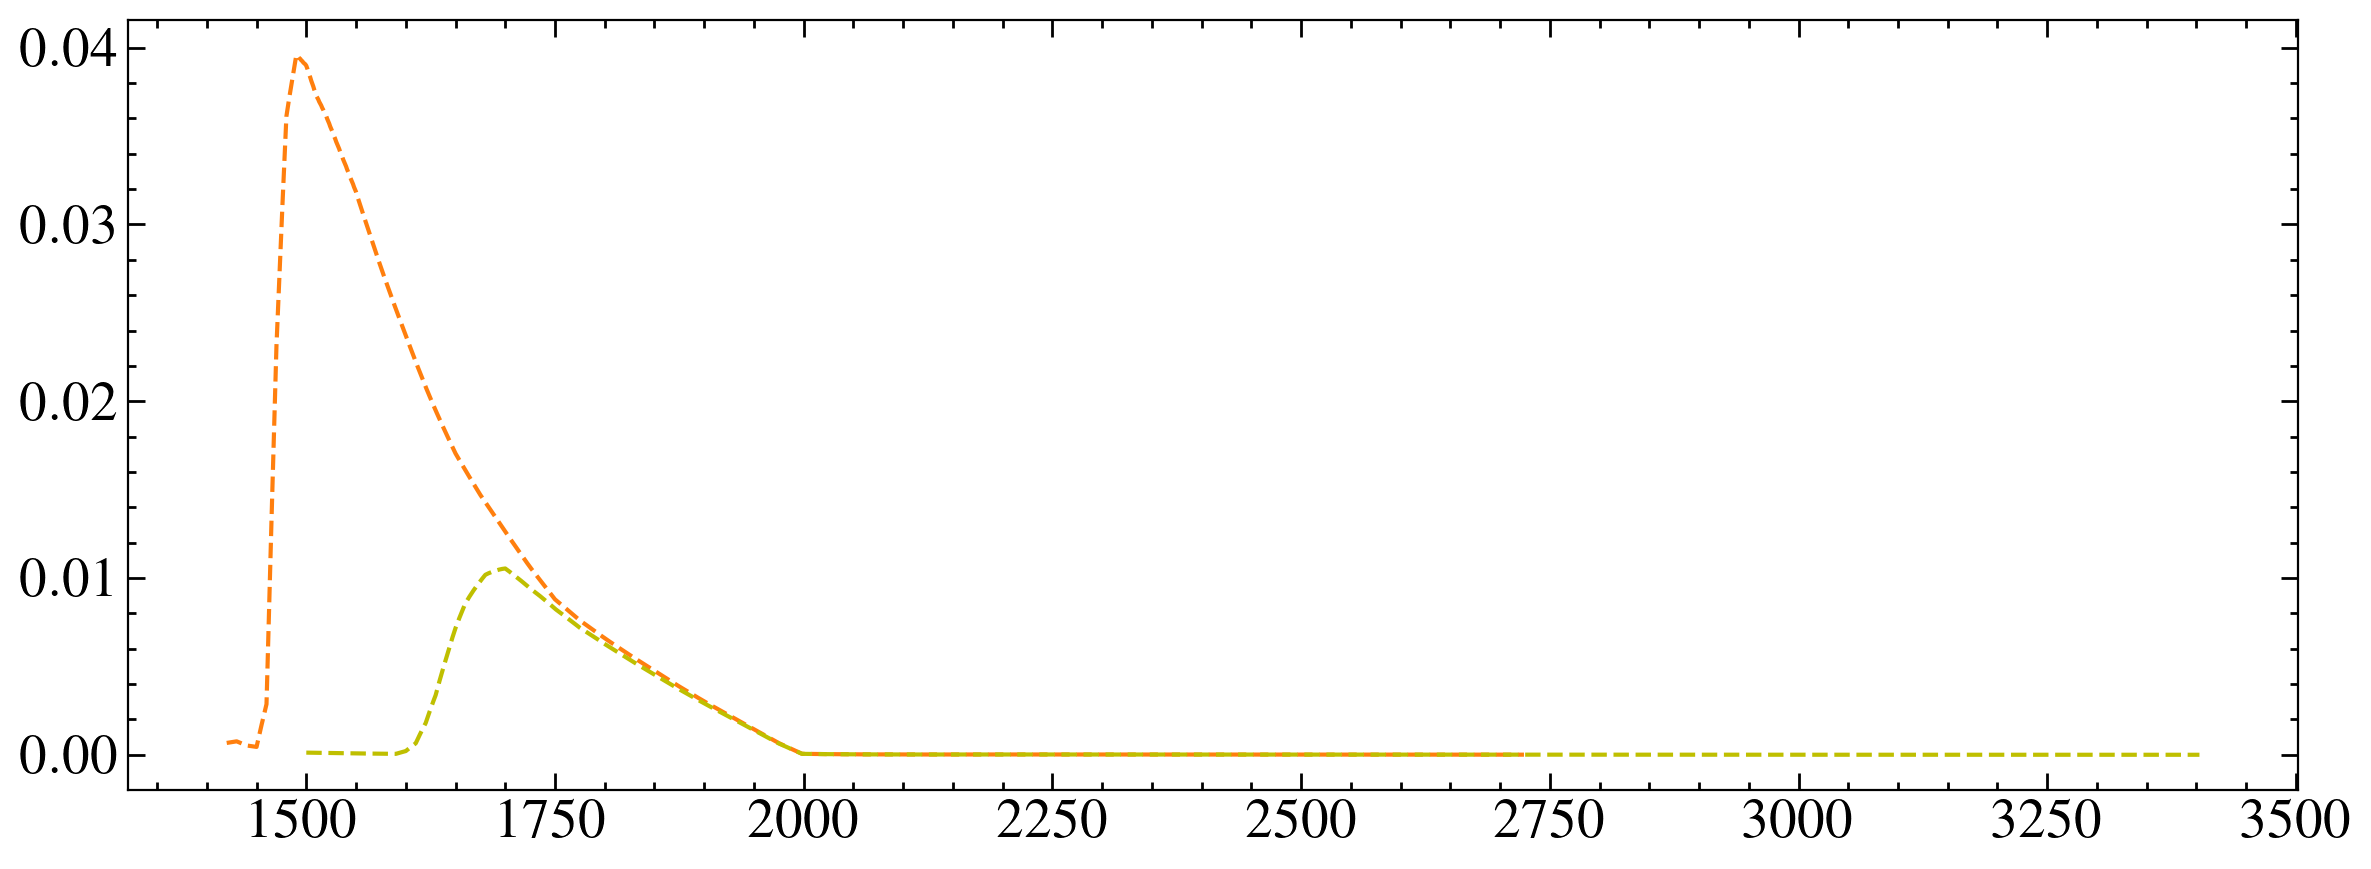

In [73]:
cols = ['C1', 'y']
names = ['F150LP', 'F165LP']
for i, band in enumerate(abands):
    bpw, bpf = np.loadtxt(band, unpack=True)
    bpws.append(bpw)
    bpfs.append(bpf)
    plt.plot(bpw, bpf, ls ='--', c=cols[i], label = names[i])
# plt.yscale('log')

In [31]:
def make_phot(bp_w, bp_cc, w, f):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

1.6525937544538437e-16
1.7276267992889147e-16
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=-0.)>

    [1]: <Gaussian1D(amplitude=0., mean=1547.92518575, stddev=0.14742435)>

    [2]: <Gaussian1D(amplitude=0., mean=1550.50018575, stddev=0.09843316)>
Parameters:
          amplitude_0            amplitude_1       ...       stddev_2     
    ----------------------- ---------------------- ... -------------------
    -1.3686289413982405e-18 3.0780304284440487e-16 ... 0.09843315856382574
[1.14366326e-18 1.41527019e-17 7.74491448e-03 7.35562200e-03
 1.67248621e-17 8.44783205e-03]


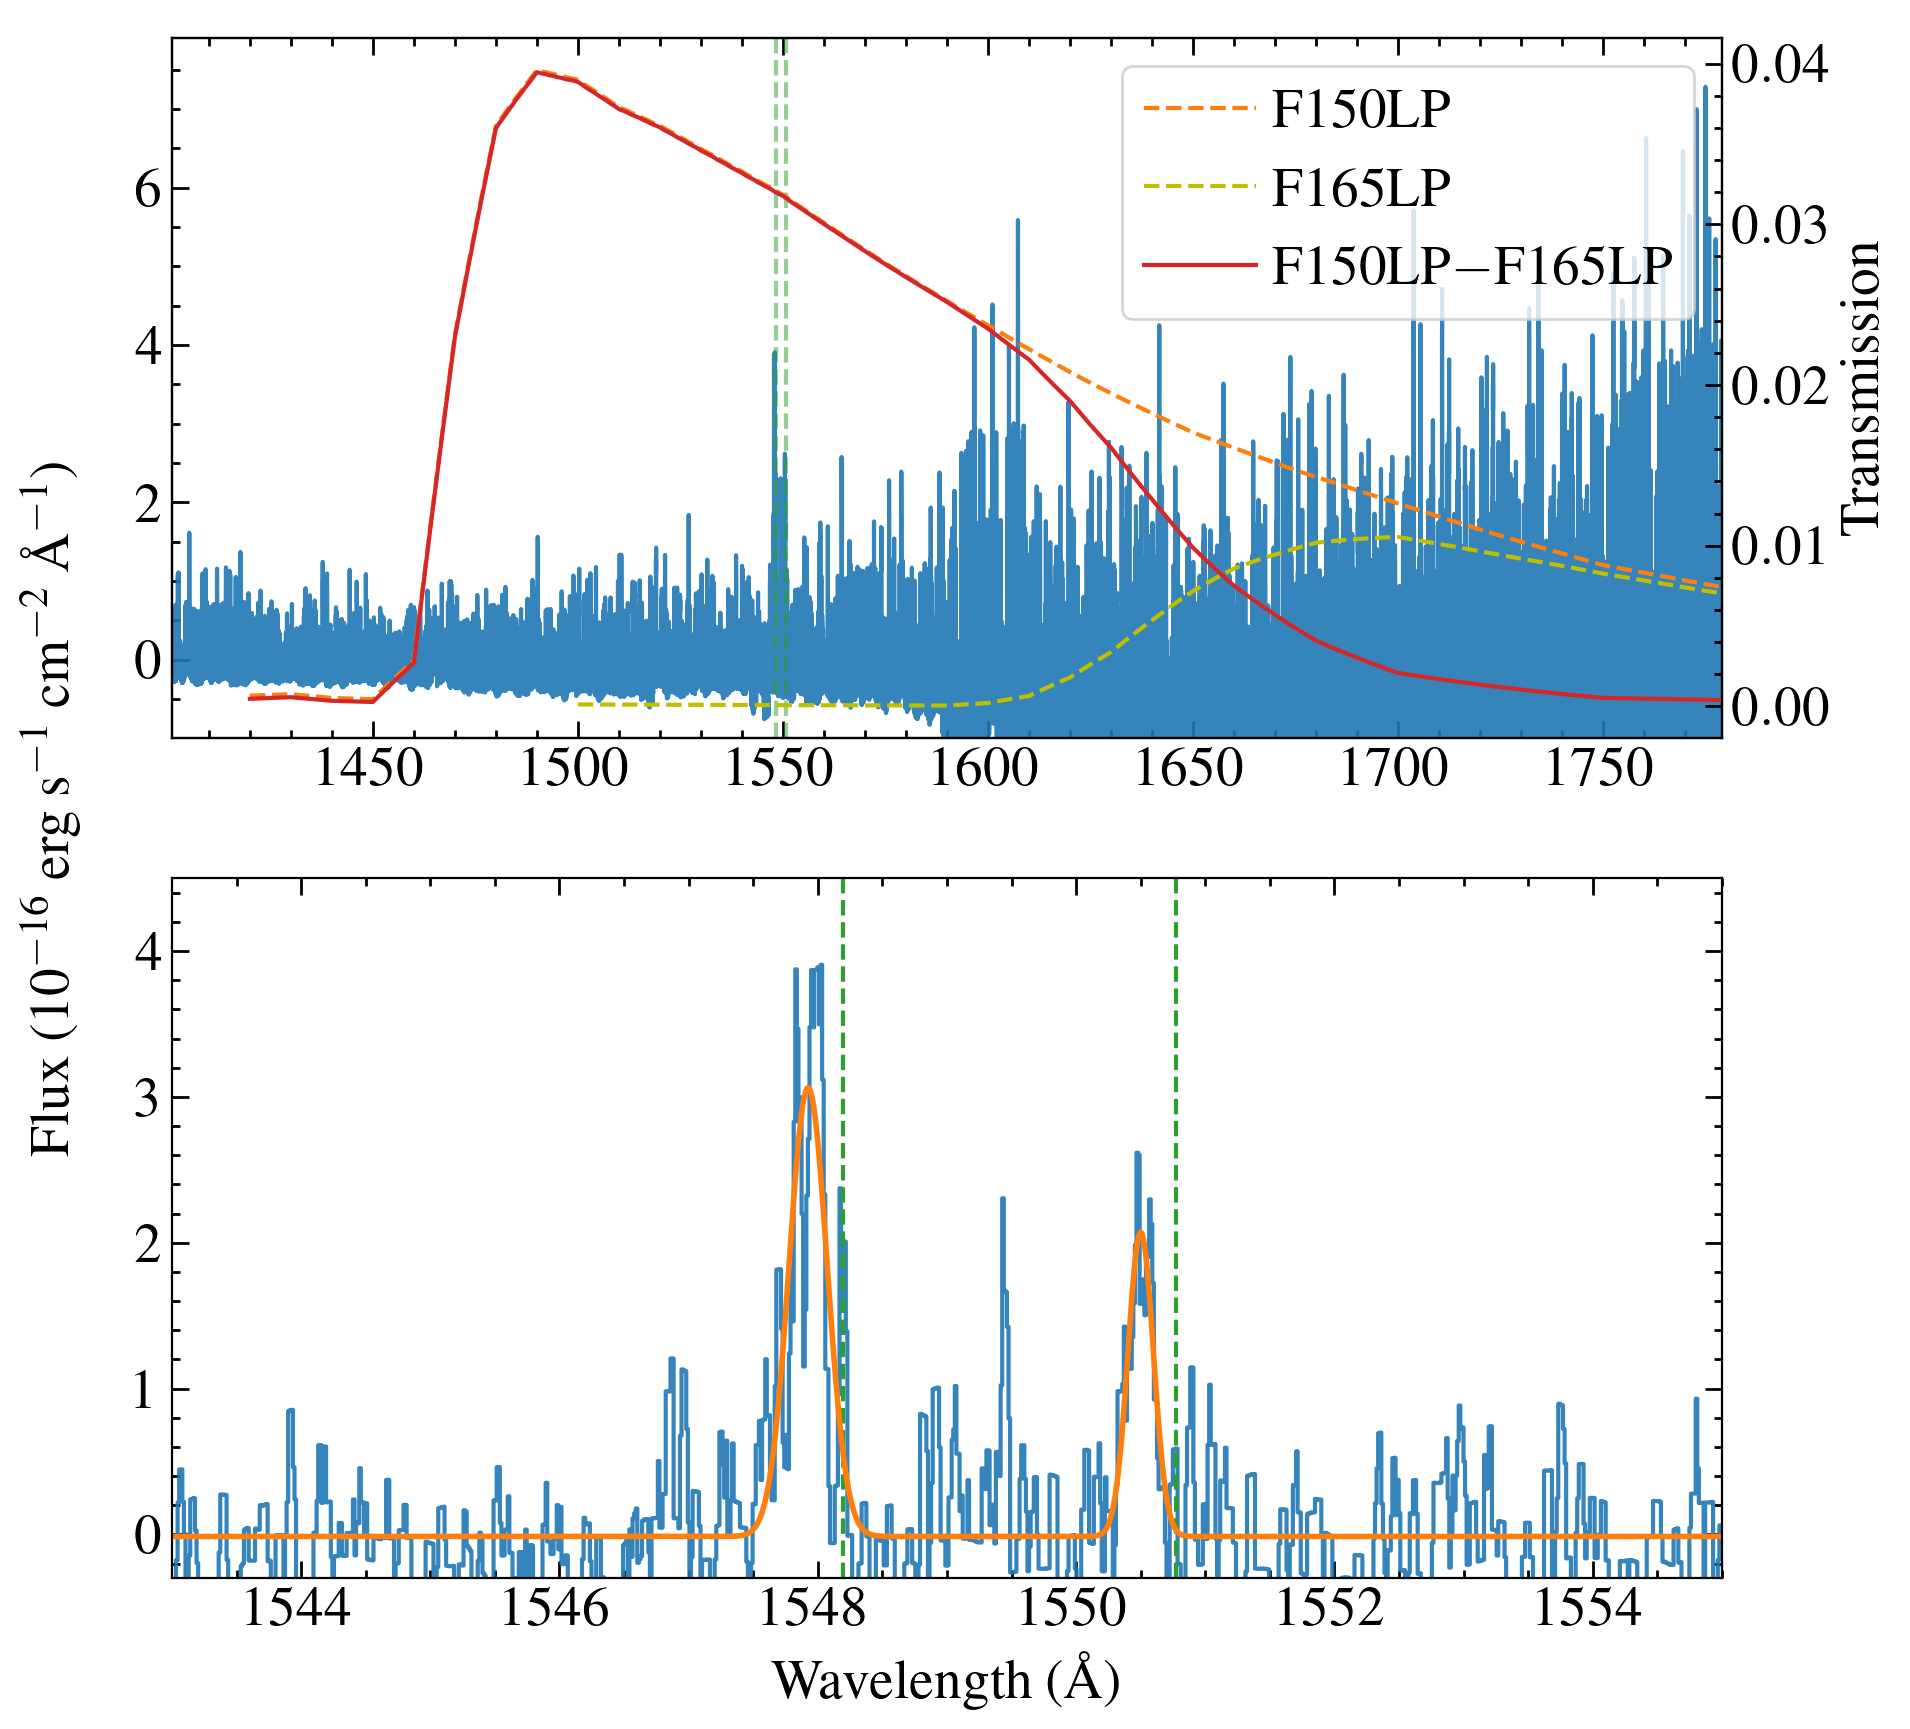

In [88]:
#w+20 sed.

civ = [1548.195, 1550.77]


fig, [ax1, ax2]=plt.subplots(nrows =2, figsize=(10, 10))
spec = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/TRAPPIST-1/hlsp_muscles_hst_cos_trappist-1_g160m_v24_component-spec.fits')
w, f, e = spec['WAVELENGTH'], spec['FLUX'], spec['ERROR']
smooth = 5
f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)

ax1.step(w, f*1e16, where='mid', alpha=0.9)
# ax.step(w, e*1e16, where='mid', alpha = 0.5)

bpws = []
bpfs = []

axr = ax1.twinx()

cols = ['C1', 'y']
names = ['F150LP', 'F165LP']
for i, band in enumerate(abands):
    bpw, bpf = np.loadtxt(band, unpack=True)
    bpws.append(bpw)
    bpfs.append(bpf)
    axr.plot(bpw, bpf, ls ='--', c=cols[i], label = names[i])
    
bfi = interp1d(bpws[1], bpfs[1], fill_value='extrapolate')(bpws[0])
bpsumw = bpws[0] 
bpsum = bpfs[0] - bfi

axr.plot(bpws[0], bpsum, c='C3', label =r'F150LP$-$F165LP')

# simphot = make_phot(bpsumw, bpsum, w, f)

# print(simphot)

[ax1.axvline(line, ls='--', c='C2', alpha =0.5) for line in civ]


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax1.set_xlim(1401, 1779)
ax1.set_ylim(-1, 7.9)
axr.set_ylabel('Transmission')




# fig, ax = plt.subplots()
# ax.step(w, f, where='mid')
# ax.step(w, e, where='mid', alpha = 0.5)


ax2.set_xlim(1543, 1555)
ax2.set_ylim(-0.3, 4.5)




fitter = fitting.LevMarLSQFitter()

# civ = [1548.195, 1550.77]
# os = [6.08e-01, 3.03e-01]

mask = (w > 1540) & (w < 1560)
wn, fn, en = w[mask], f[mask], e[mask]

ax2.step(wn, fn*1e16, where='mid', alpha=0.9)
# ax.step(wn, en, where='mid', alpha = 0.5)

# plt.plot(wp, fp)
# plt.yscale('log')
[ax2.axvline(line, ls='--', c='C2') for line in civ]

lines = np.copy(civ)

mod = models.Const1D(0)#, fixed=dict(amplitude=True))
for line in lines:
    line_guess = (-63*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
    mod = mod+  models.Gaussian1D(amplitude=np.max(fn), mean = line_guess, stddev=0.1)
    # mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1, bounds=dict(amplitude_L=[0, 1]))
    # plt.axvline(line, ls='--', c='C2', alpha =0.5)
#     plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

def tiedfunc0(mod):
    mean = mod.mean_1.value+np.diff(lines)
    return mean


def tiedfunc1(mod):
    x_0 = mod.x_0_1.value+np.diff(lines)
    # fwhm_G = mod.fwhm_G_1.value
    return x_0

def tiedfwhmg(mod):
    fwhm_G = mod.fwhm_G_1.value
    return fwhm_G

def tiedfwhml(mod):
    fwhm_L = mod.fwhm_L_1.value
    return fwhm_L

# def tiedamp(mod):
#     amplitude_L = mod.amplitude_L_1.value/(os[0]/os[1])
#     return amplitude_L

def tiedamp(mod):
    amplitude = mod.amplitude_1.value/(os[0]/os[1])
    return amplitude

mod.mean_2.tied=tiedfunc0
# mod.x_0_2.tied=tiedfunc1
# mod.fwhm_G_2.tied=tiedfwhmg
# mod.fwhm_L_2.tied=tiedfwhml
# mod.amplitude_2.tied = tiedamp

# gg_fit = fitter(mod, wn, fn, maxiter=100000)
gg_fit = fitter(mod, wn, fn, weights =1/np.median(en), maxiter=100000)

# print(gg_fit)


if type(fitter.fit_info['param_cov']) == np.ndarray:
#     print('hooray!')
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#     print(fit_e)
    
ax2.plot(wn, gg_fit(wn)*1e16, c='C1', lw=2)
gg_fit

print(np.trapz(gg_fit(wn), wn) - np.trapz(gg_fit[0](wn), wn))

mask2 = (wn > 1547.4) & (wn < 1547.7) | (wn > 1550.0) & (wn < 1550.2)
print(np.trapz(fn[mask2], wn[mask2]))


print(gg_fit)
print(fit_e)

bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_xlabel('Wavelength (\AA)')
bigax.set_ylabel('Flux (10$^{-16}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

fig.savefig('plots/cos_fuv_fit.pdf')

#[1.14385499e-18 1.40657309e-17 7.75008501e-03 7.39216559e-03
#  1.67535421e-17 8.41897035e-03]

Need to fit to spectrum.

1.6525937544538437e-16
1.7276267992889147e-16
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=-0.)>

    [1]: <Gaussian1D(amplitude=0., mean=1547.92518575, stddev=0.14742435)>

    [2]: <Gaussian1D(amplitude=0., mean=1550.50018575, stddev=0.09843316)>
Parameters:
          amplitude_0            amplitude_1       ...       stddev_2     
    ----------------------- ---------------------- ... -------------------
    -1.3686289413982405e-18 3.0780304284440487e-16 ... 0.09843315856382574
[1.14366326e-18 1.41527019e-17 7.74491448e-03 7.35562200e-03
 1.67248621e-17 8.44783205e-03]


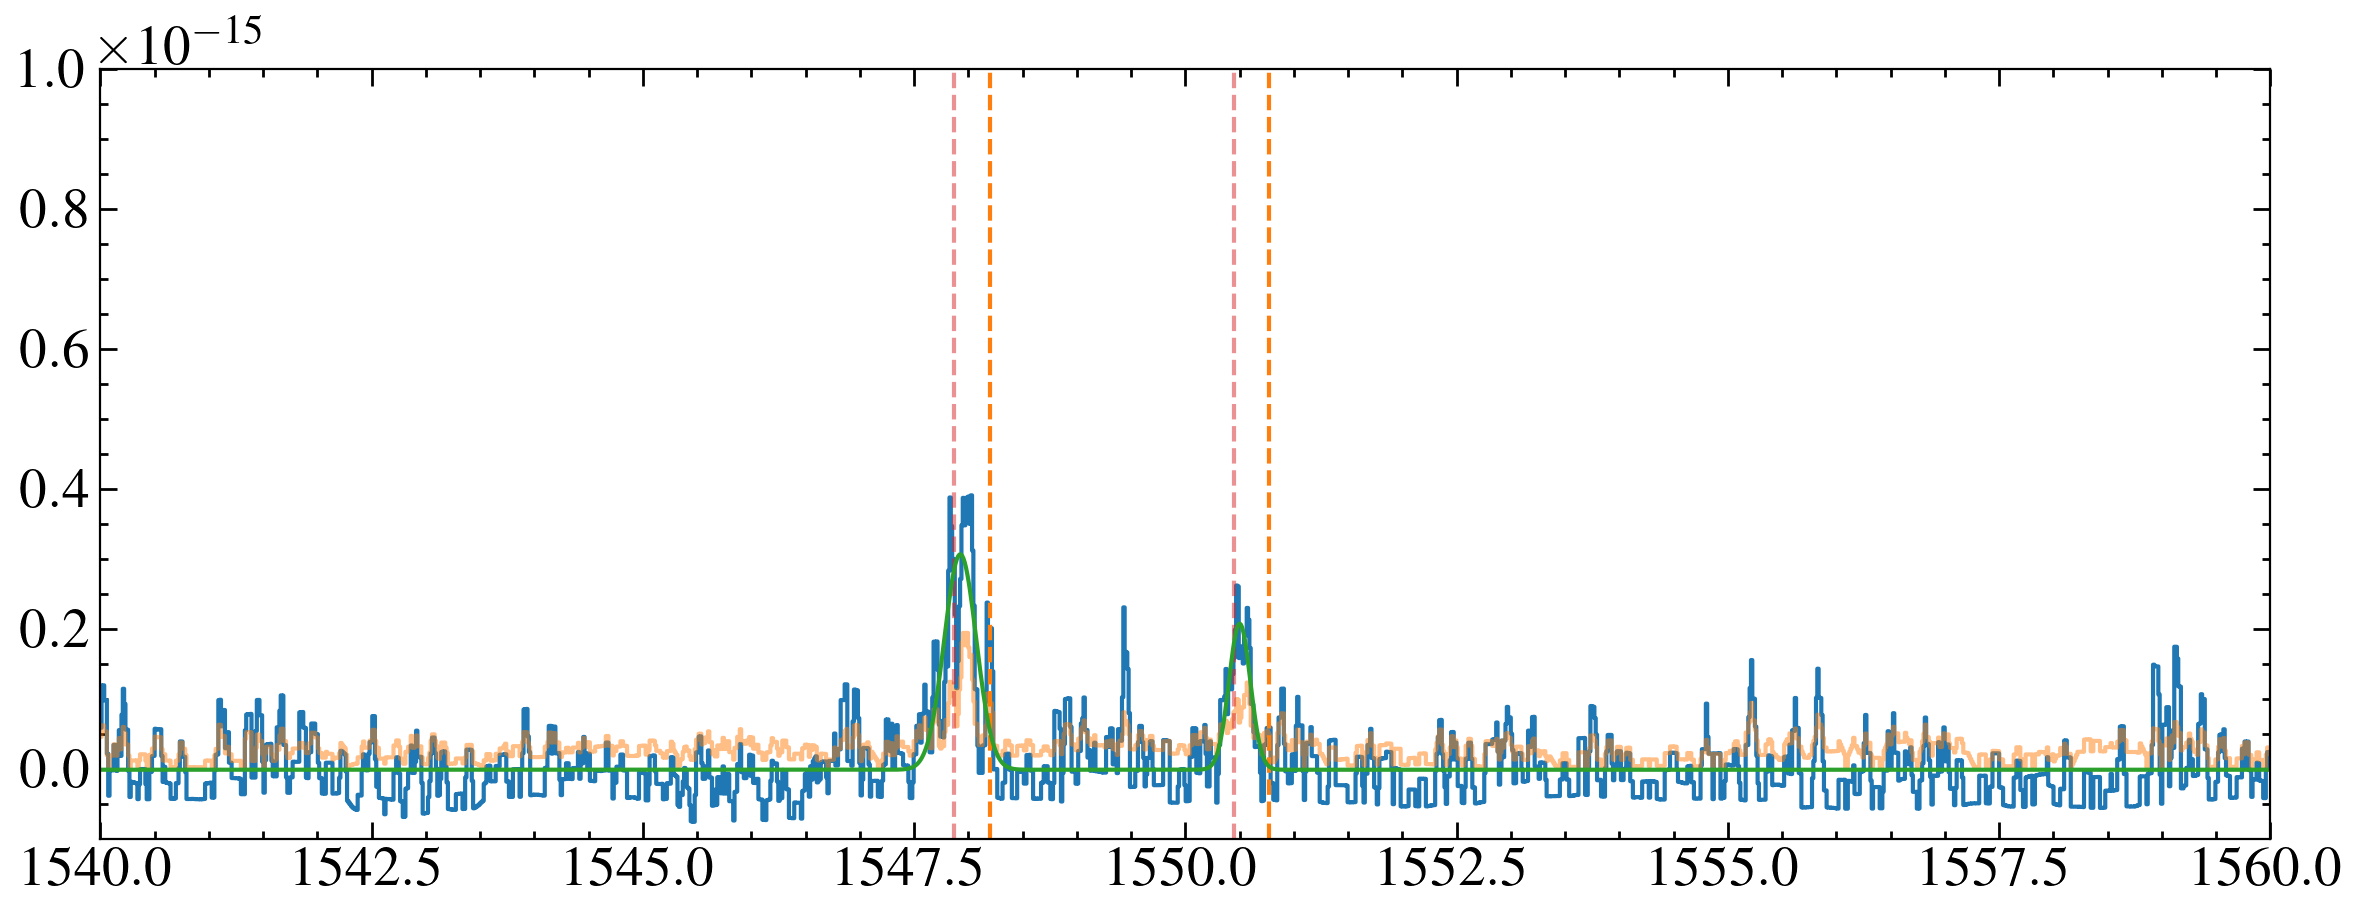

In [39]:
fig, ax = plt.subplots()
# ax.step(w, f, where='mid')
# ax.step(w, e, where='mid', alpha = 0.5)


ax.set_xlim(1540, 1560)
ax.set_ylim(-1e-16, 1e-15)




fitter = fitting.LevMarLSQFitter()

civ = [1548.195, 1550.77]
# os = [6.08e-01, 3.03e-01]

mask = (w > 1540) & (w < 1560)
wn, fn, en = w[mask], f[mask], e[mask]

ax.step(wn, fn, where='mid')
ax.step(wn, en, where='mid', alpha = 0.5)

# plt.plot(wp, fp)
# plt.yscale('log')
[plt.axvline(line, ls='--', c='C1') for line in civ]

lines = np.copy(civ)

mod = models.Const1D(0)#, fixed=dict(amplitude=True))
for line in lines:
    line_guess = (-63*u.km/u.s).to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
    mod = mod+  models.Gaussian1D(amplitude=np.max(fn), mean = line_guess, stddev=0.1)
    # mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fn), fwhm_G=1, fwhm_L=1, bounds=dict(amplitude_L=[0, 1]))
    # plt.axvline(line, ls='--', c='C2', alpha =0.5)
    plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)

def tiedfunc0(mod):
    mean = mod.mean_1.value+np.diff(lines)
    return mean


def tiedfunc1(mod):
    x_0 = mod.x_0_1.value+np.diff(lines)
    # fwhm_G = mod.fwhm_G_1.value
    return x_0

def tiedfwhmg(mod):
    fwhm_G = mod.fwhm_G_1.value
    return fwhm_G

def tiedfwhml(mod):
    fwhm_L = mod.fwhm_L_1.value
    return fwhm_L

# def tiedamp(mod):
#     amplitude_L = mod.amplitude_L_1.value/(os[0]/os[1])
#     return amplitude_L

def tiedamp(mod):
    amplitude = mod.amplitude_1.value/(os[0]/os[1])
    return amplitude

mod.mean_2.tied=tiedfunc0
# mod.x_0_2.tied=tiedfunc1
# mod.fwhm_G_2.tied=tiedfwhmg
# mod.fwhm_L_2.tied=tiedfwhml
# mod.amplitude_2.tied = tiedamp

# gg_fit = fitter(mod, wn, fn, maxiter=100000)
gg_fit = fitter(mod, wn, fn, weights =1/np.median(en), maxiter=100000)

# print(gg_fit)


if type(fitter.fit_info['param_cov']) == np.ndarray:
#     print('hooray!')
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#     print(fit_e)
    
ax.plot(wn, gg_fit(wn))
gg_fit

print(np.trapz(gg_fit(wn), wn) - np.trapz(gg_fit[0](wn), wn))

mask2 = (wn > 1547.4) & (wn < 1547.7) | (wn > 1550.0) & (wn < 1550.2)
print(np.trapz(fn[mask2], wn[mask2]))


print(gg_fit)
print(fit_e)



#[1.14385499e-18 1.40657309e-17 7.75008501e-03 7.39216559e-03
#  1.67535421e-17 8.41897035e-03]

In [34]:
# modw = np.arange(1300, 2000, 0.01)
# modf = gg_fit[1](modw) + gg_fit[2](modw)

# simphot = make_phot(bpsumw, bpsum, modw, modf)

# print(simphot*1e18)
# # print(gg_fit[0])

# n = 1000
# i = 0
# phots = []

# amp1 = np.random.normal(gg_fit[1].amplitude.value, fit_e[1], n)
# amp2 = np.random.normal(gg_fit[2].amplitude.value, fit_e[4], n)
# std1 = np.random.normal(gg_fit[1].stddev.value, fit_e[3], n)
# std2 = np.random.normal(gg_fit[2].stddev.value, fit_e[5], n)


# while i < n:
#     modi = models.Gaussian1D(amp1[i], gg_fit[1].mean.value, std1[i]) + models.Gaussian1D(amp2[i], gg_fit[2].mean.value, std2[i])
#     fmodi = modi(modw)
#     plt.plot(modw, fmodi, c='C0', alpha=0.01)
#     simphoti = make_phot(bpsumw, bpsum, modw, fmodi)
#     phots.append(simphoti)
#     i +=1
    
# plt.xlim(1545, 1555)
# [plt.axvline(line, ls='--', c='C1') for line in civ]

# plt.show()

# plt.hist(phots)

# print(np.mean(phots), np.median(phots), np.std(phots))

simphot, simphot_e = 9.459369456324885e-19,5.708173610402945e-20





[2.86098203 0.72777834 1.95636721]
8.056000545722419e-19 2.335596056473362e-19
3.4492268144546334


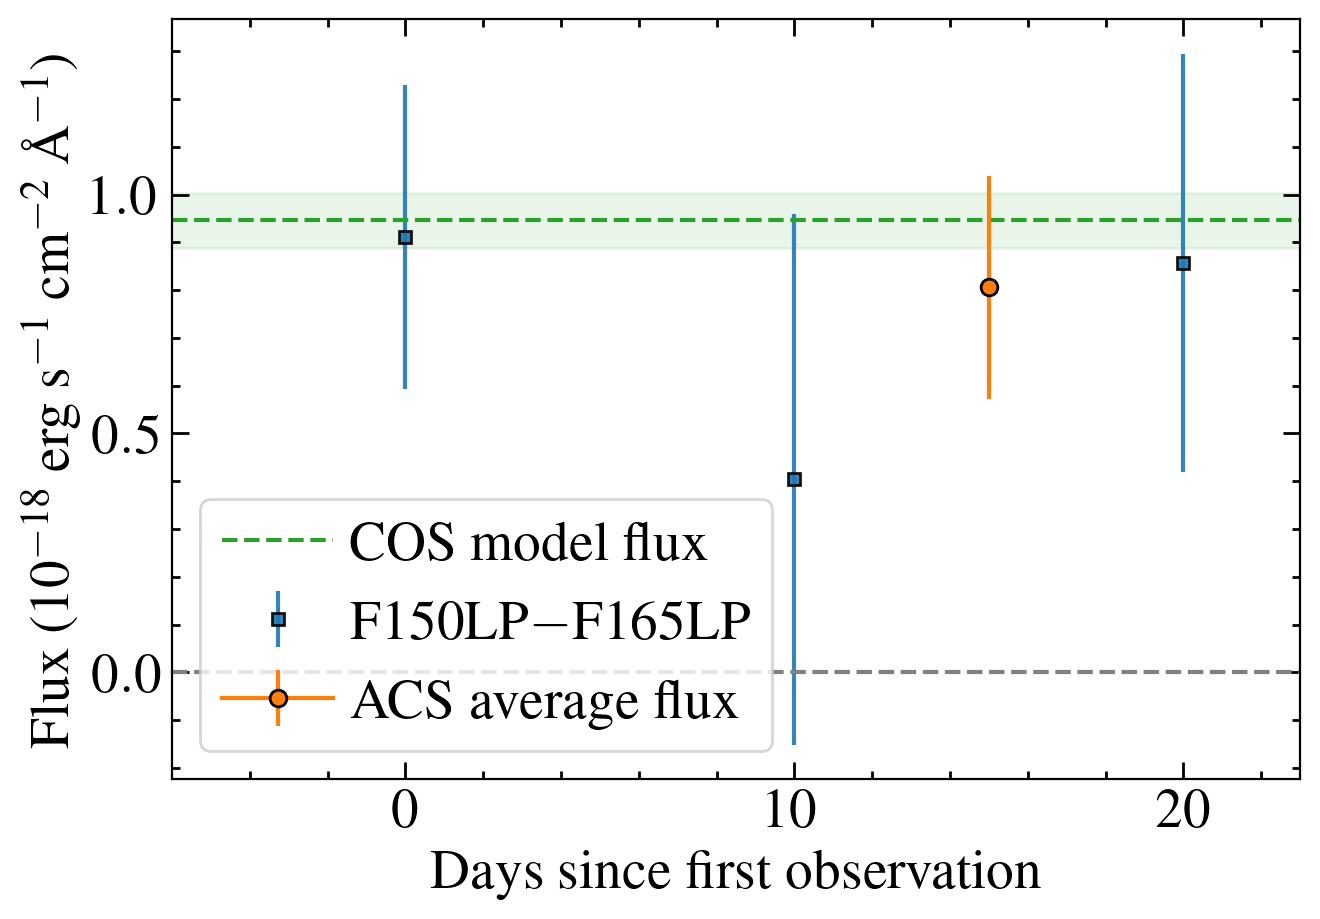

In [97]:
fig, ax = plt.subplots(figsize=(7, 5))
scale = 1e18

#2023-06-20, 2023-06-30, 2023-07-10 
days = [0, 10, 20]

# cols = [0, 1, 2]

ax.errorbar(days, fdiff*scale, yerr=fdiff_e*scale, label = 'F150LP$-$F165LP', marker='s', c='C0', markeredgecolor='k', markersize=4, alpha=0.9, ls='none')

simphot, simphot_e = 9.459369456324885e-19,5.708173610402945e-20

x = np.arange(-10, 40)

ax.axhline(simphot*scale, ls = '--', c='C2', label = 'COS model flux')
ax.fill_between(x, (simphot-simphot_e)*scale, (simphot+simphot_e)*scale , color='C2', alpha=0.1)

ax.axhline(0, ls ='--', c='0.5')


print(fdiff/fdiff_e)

 
fdiff_av = np.average(fdiff, weights = 1/(fdiff_e**2))
fdiff_ave = (1/(np.sum(1/(fdiff_e**2))))**0.5
ax.errorbar(15., fdiff_av*scale, yerr=fdiff_ave*scale, c='C1', marker='o', markeredgecolor='k', label = 'ACS average flux')


print(fdiff_av, fdiff_ave)
print(fdiff_av/fdiff_ave)

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=4) 


# fig.tight_layout()


# ax.set_yscale('log')
ax.set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Days since first observation')
ax.set_xticks(days)

ax.set_xlim(-6, 23)
# ax.set_ylim(2.1, 7.9)

    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=3) 

fig.tight_layout()
fig.savefig('plots/acs_diff_flux.pdf')

F150LP 0.4121697600057814
F165LP 0.4780956899994635
F150LP 10.185052169996197
F165LP 10.250943095001276
F150LP 21.078061054999125
F165LP 21.143975874998432


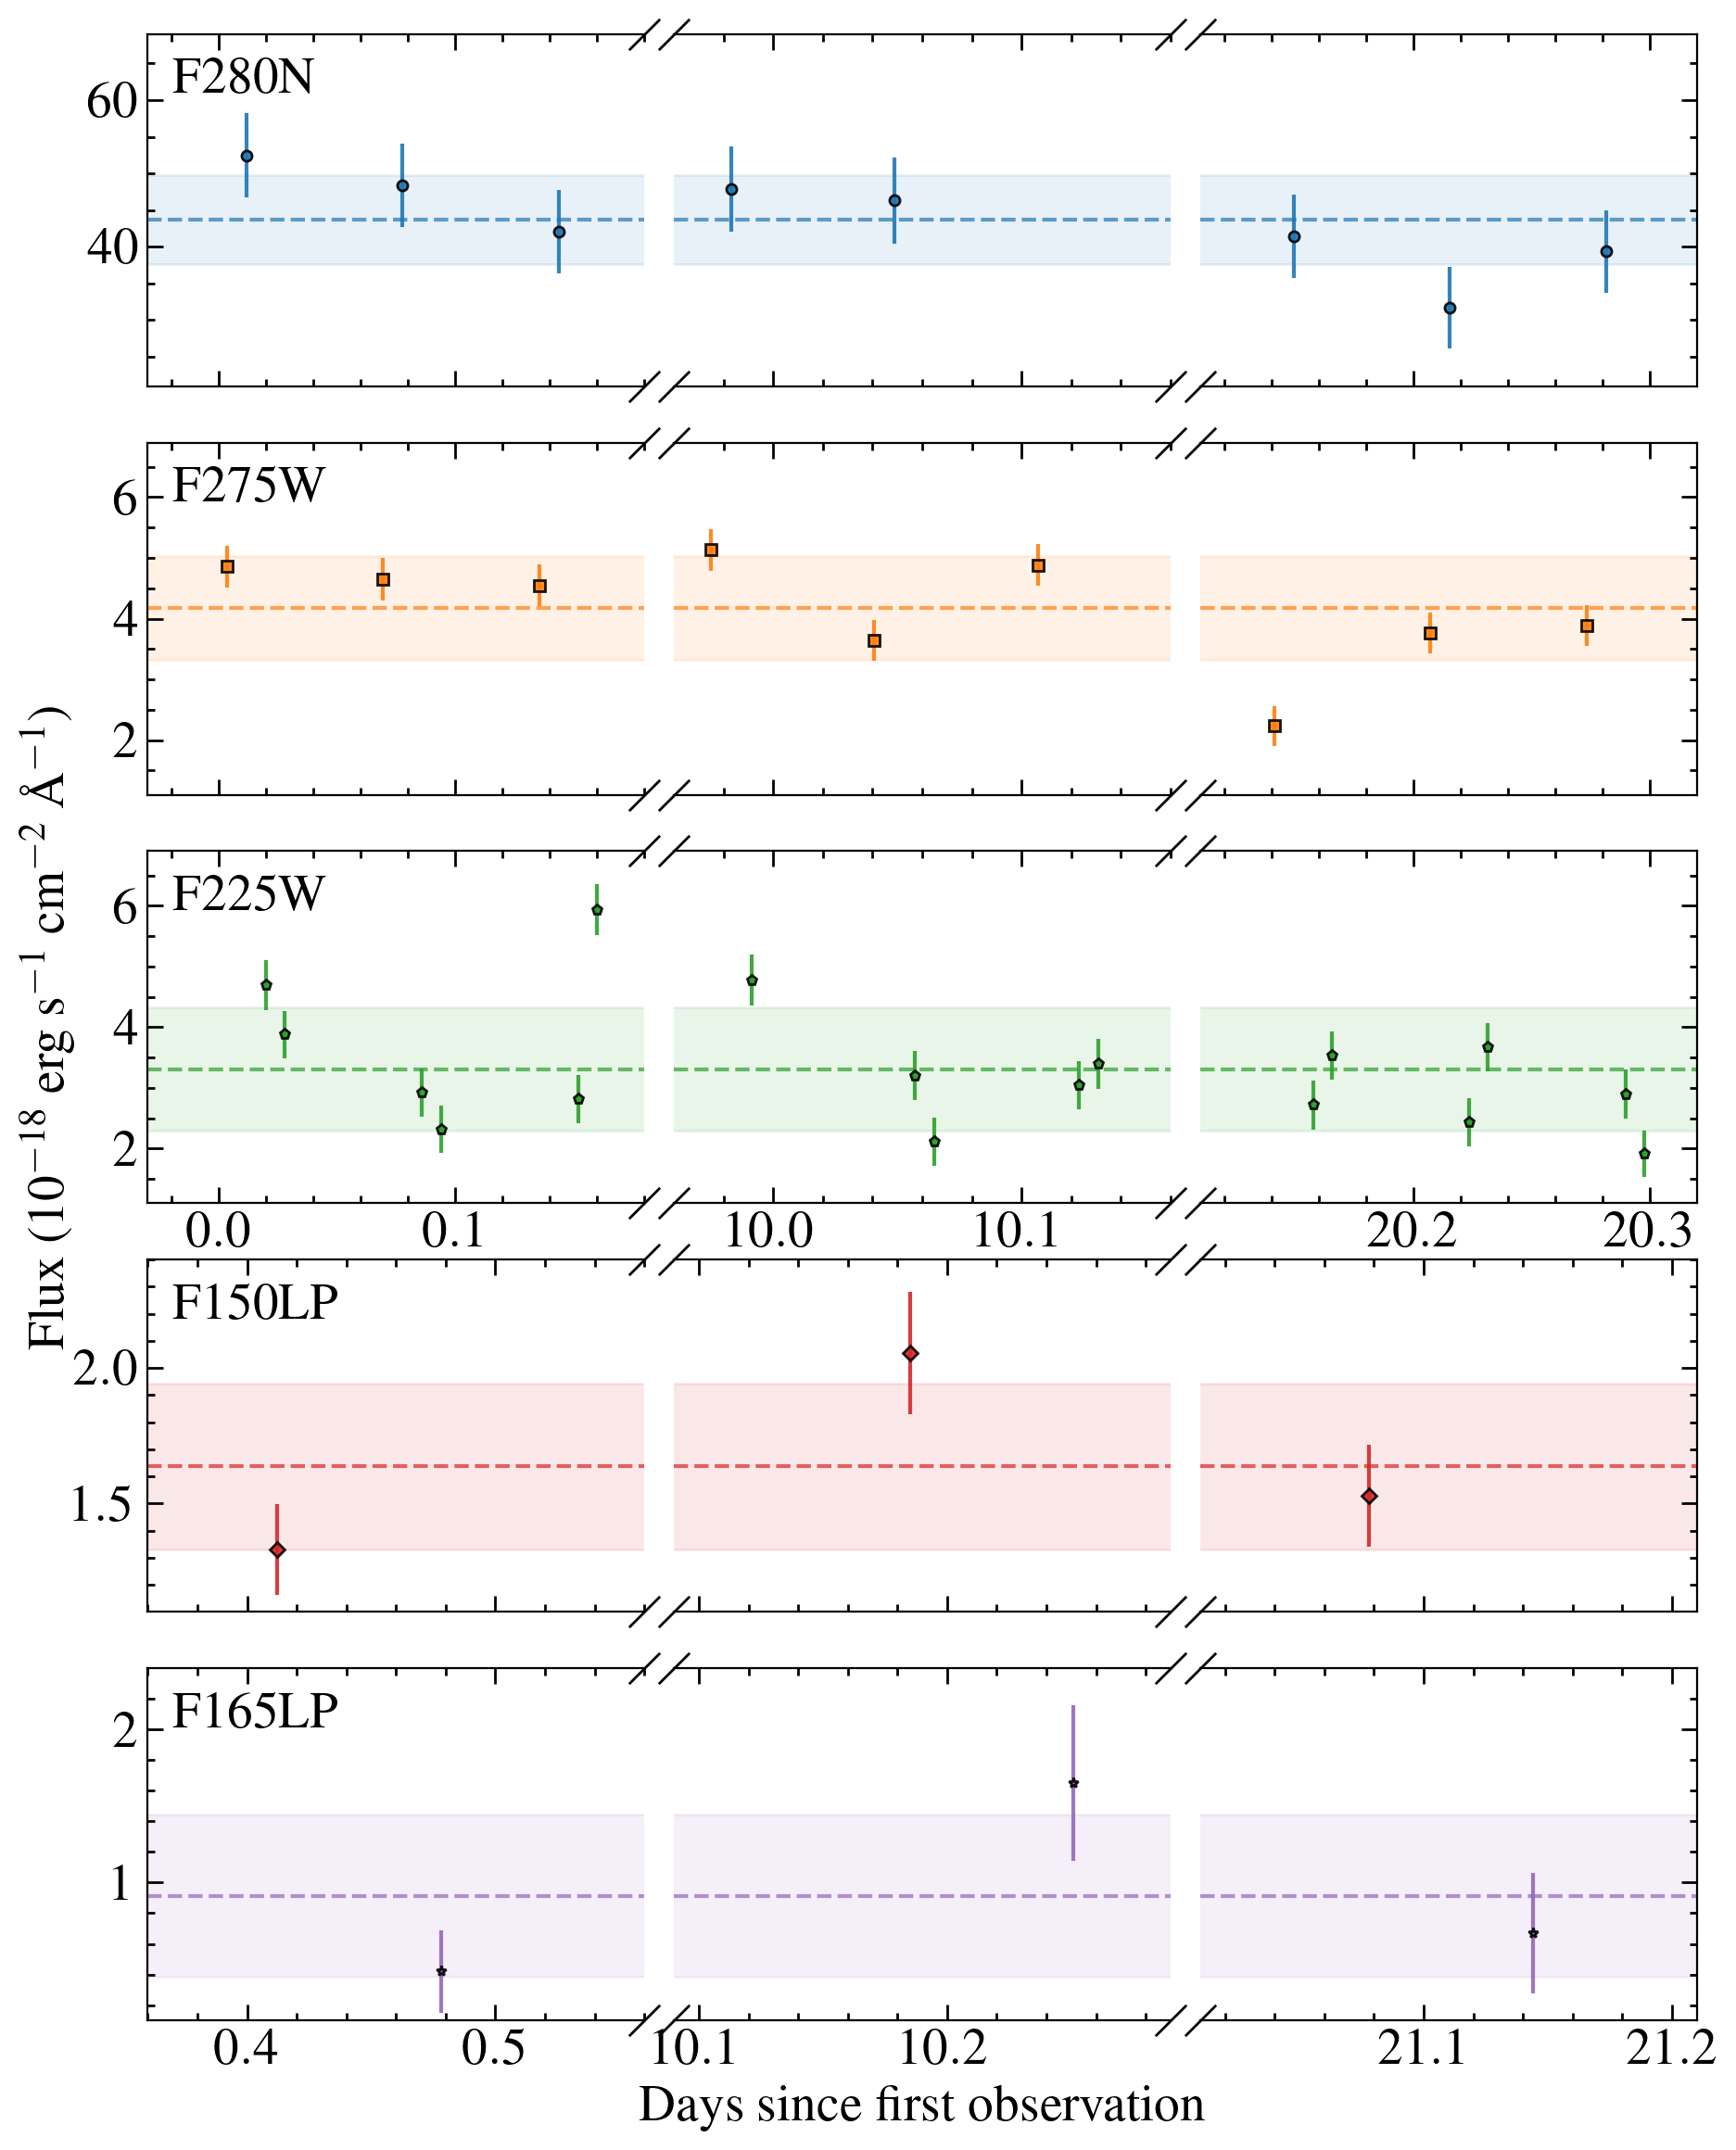

In [101]:
# fig, ax = plt.subplots(figsize=(6, 6))
# scale = 1e18

# #2023-06-20, 2023-06-30, 2023-07-10 
# days = [0, 10, 20]

# # cols = [0, 1, 2]



# fig.tight_layout()
# fig.savefig('plots/wfc3_all_visits.pdf')

fig, ax= plt.subplots(ncols=3, nrows=5, figsize=(10, 12))#, sharey=True)

# plot the same data on both axes
# ax1.plot(pts)
# ax2.plot(pts)

ax[0, 0].set_xlim(-0.03, 0.18) 
ax[0, 1].set_xlim(9.96, 10.16)  
ax[0, 2].set_xlim(20.11, 20.32)  
ax[1, 0].set_xlim(-0.03, 0.18) 
ax[1, 1].set_xlim(9.96, 10.16)  
ax[1, 2].set_xlim(20.11, 20.32)  
ax[2, 0].set_xlim(-0.03, 0.18) 
ax[2, 1].set_xlim(9.96, 10.16)  
ax[2, 2].set_xlim(20.11, 20.32)

ax[3, 0].set_xlim(0.36, 0.56) 
ax[3, 1].set_xlim(10.09, 10.29)  
ax[3, 2].set_xlim(21.01, 21.21)  
ax[4, 0].set_xlim(0.36, 0.56) 
ax[4, 1].set_xlim(10.09, 10.29)  
ax[4, 2].set_xlim(21.01, 21.21)  


ax[0, 0].set_ylim(21, 69)
ax[0, 1].set_ylim(21, 69)
ax[0, 2].set_ylim(21, 69)
ax[1, 0].set_ylim(1.1, 6.9)
ax[1, 1].set_ylim(1.1, 6.9)
ax[1, 2].set_ylim(1.1, 6.9)
ax[2, 0].set_ylim(1.1, 6.9)
ax[2, 1].set_ylim(1.1, 6.9)
ax[2, 2].set_ylim(1.1, 6.9)

ax[3, 0].set_ylim(1.1, 2.4)
ax[3, 1].set_ylim(1.1, 2.4)
ax[3, 2].set_ylim(1.1, 2.4)
ax[4, 0].set_ylim(0.1, 2.4)
ax[4, 1].set_ylim(0.1, 2.4)
ax[4, 2].set_ylim(0.1, 2.4)




# # hide the spines between ax and ax2
ax[0,0].spines.right.set_visible(False)
ax[1,0].spines.right.set_visible(False)
ax[2,0].spines.right.set_visible(False)
ax[3,0].spines.right.set_visible(False)
ax[4,0].spines.right.set_visible(False)

ax[0,0].yaxis.tick_left()
ax[1,0].yaxis.tick_left()
ax[2,0].yaxis.tick_left()
ax[3,0].yaxis.tick_left()
ax[4,0].yaxis.tick_left()

ax[0,1].spines.right.set_visible(False)
ax[0,1].spines.left.set_visible(False)
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.left.set_visible(False)
ax[3,1].spines.right.set_visible(False)
ax[3,1].spines.left.set_visible(False)
ax[4,1].spines.right.set_visible(False)
ax[4,1].spines.left.set_visible(False)


ax[0,1].tick_params(right = False, left=False, which='both')
ax[1,1].tick_params(right = False, left=False, which='both')
ax[2,1].tick_params(right = False, left=False, which='both')
ax[3,1].tick_params(right = False, left=False, which='both')
ax[4,1].tick_params(right = False, left=False, which='both')
ax[0, 1].yaxis.set_tick_params(labelleft=False)
ax[1, 1].yaxis.set_tick_params(labelleft=False)
ax[2, 1].yaxis.set_tick_params(labelleft=False)
ax[3, 1].yaxis.set_tick_params(labelleft=False)
ax[4, 1].yaxis.set_tick_params(labelleft=False)


ax[0,2].spines.left.set_visible(False)
ax[0,2].yaxis.tick_right()
ax[1,2].spines.left.set_visible(False)
ax[1,2].yaxis.tick_right()
ax[2,2].spines.left.set_visible(False)
ax[2,2].yaxis.tick_right()
ax[3,2].spines.left.set_visible(False)
ax[3,2].yaxis.tick_right()
ax[4,2].spines.left.set_visible(False)
ax[4,2].yaxis.tick_right()

ax[0, 2].yaxis.set_tick_params(labelright=False)
ax[1, 2].yaxis.set_tick_params(labelright=False)
ax[2, 2].yaxis.set_tick_params(labelright=False)
ax[3, 2].yaxis.set_tick_params(labelright=False)
ax[4, 2].yaxis.set_tick_params(labelright=False)


ax[0, 0].xaxis.set_tick_params(labelbottom=False)
ax[0, 1].xaxis.set_tick_params(labelbottom=False)
ax[0, 2].xaxis.set_tick_params(labelbottom=False)
ax[1, 0].xaxis.set_tick_params(labelbottom=False)
ax[1, 1].xaxis.set_tick_params(labelbottom=False)
ax[1, 2].xaxis.set_tick_params(labelbottom=False)

ax[3, 0].xaxis.set_tick_params(labelbottom=False)
ax[3, 1].xaxis.set_tick_params(labelbottom=False)
ax[3, 2].xaxis.set_tick_params(labelbottom=False)


# # Now, let's turn towards the cut-out slanted lines.
# # We create line objects in axes coordinates, in which (0,0), (0,1),
# # (1,0), and (1,1) are the four corners of the axes.
# # The slanted lines themselves are markers at those locations, such that the
# # lines keep their angle and position, independent of the axes size or scale
# # Finally, we need to disable clipping.

d = 1.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0,0].plot([1, 1], [0, 1], transform=ax[0,0].transAxes, **kwargs)
ax[0,1].plot([0, 1], [1, 1], transform=ax[0,1].transAxes, **kwargs)
ax[0,1].plot([0, 1], [0, 0], transform=ax[0, 1].transAxes, **kwargs)
ax[0,2].plot([0, 0], [1, 0], transform=ax[0,2].transAxes, **kwargs)

ax[1,0].plot([1, 1], [0, 1], transform=ax[1,0].transAxes, **kwargs)
ax[1,1].plot([0, 1], [1, 1], transform=ax[1,1].transAxes, **kwargs)
ax[1,1].plot([0, 1], [0, 0], transform=ax[1, 1].transAxes, **kwargs)
ax[1,2].plot([0, 0], [1, 0], transform=ax[1,2].transAxes, **kwargs)

ax[2,0].plot([1, 1], [0, 1], transform=ax[2,0].transAxes, **kwargs)
ax[2,1].plot([0, 1], [1, 1], transform=ax[2,1].transAxes, **kwargs)
ax[2,1].plot([0, 1], [0, 0], transform=ax[2, 1].transAxes, **kwargs)
ax[2,2].plot([0, 0], [1, 0], transform=ax[2,2].transAxes, **kwargs)

ax[3,0].plot([1, 1], [0, 1], transform=ax[3,0].transAxes, **kwargs)
ax[3,1].plot([0, 1], [1, 1], transform=ax[3,1].transAxes, **kwargs)
ax[3,1].plot([0, 1], [0, 0], transform=ax[3, 1].transAxes, **kwargs)
ax[3,2].plot([0, 0], [1, 0], transform=ax[3,2].transAxes, **kwargs)

ax[4,0].plot([1, 1], [0, 1], transform=ax[4,0].transAxes, **kwargs)
ax[4,1].plot([0, 1], [1, 1], transform=ax[4,1].transAxes, **kwargs)
ax[4,1].plot([0, 1], [0, 0], transform=ax[4, 1].transAxes, **kwargs)
ax[4,2].plot([0, 0], [1, 0], transform=ax[4,2].transAxes, **kwargs)

# crs = ['if3i01i2q', 'if3i01i4q', 'if3i03z2q', 'if3i03zcq']
crs = ['if3i03z2q', 'if3i03zcq']

f280n = []
f275w = []
f225w= []


for i, phot in enumerate(wfc3):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:
        if row['ROOTNAME'] not in crs:
            if row['FILTER'] == 'F280N':
                c = 'C0'
                m = 'o'
                f280n.append(row['FLUX'])
                r = 0
            elif row['FILTER'] == 'F275W':
                c = 'C1'
                m ='s'
                f275w.append(row['FLUX'])
                r = 1
            elif row['FILTER'] == 'F225W':
                c = 'C2'
                m ='p'
                f225w.append(row['FLUX'])
                r = 2
            ax[r, 0].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 1].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 2].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)


            
f150lp = []
f150lp_e = []
f165lp = []
f165lp_e = []

            
for i, phot in enumerate(acs):
    data = Table.read(phot)
#     data = data[mask]
    for row in data:

            if row['FILTER'] == 'F150LP':
                c = 'C3'
                m = 'D'
                f150lp.append(row['FLUX'])
                f150lp_e.append(row['ERROR'])
                r = 3
            if row['FILTER'] == 'F165LP':
                c = 'C4'
                m ='*'
                r = 4
                f165lp.append(row['FLUX'])
                f165lp_e.append(row['ERROR'])
                
            print(row['FILTER'], ((row['EXPSTART']+row['EXPEND'])/2)-d1)
         


            ax[r, 0].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 1].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
            ax[r, 2].errorbar(((row['EXPSTART']+row['EXPEND'])/2)-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)


#             if row['FILTER'] == 'F280N':
            

            
#             else:
#                 ax1.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax2.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)
#                 ax3.errorbar(row['EXPSTART']-d1, row['FLUX']*scale, yerr=row['ERROR']*scale, label = row['FILTER'], marker=m, c=c, markeredgecolor='k', markersize=4, alpha=0.9)

# x = np.arange(-5, 30)
ax[0, 0].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,0].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 1].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,1].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)
ax[0, 2].axhline(np.mean(f280n)*scale, ls ='--', alpha=0.7, c='C0')
ax[0,2].fill_between(x, (np.mean(f280n)-np.std(f280n))*scale, (np.mean(f280n)+np.std(f280n))*scale, color='C0', alpha=0.1)



ax[1, 0].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 0].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 1].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 1].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)
ax[1, 2].axhline(np.mean(f275w)*scale, ls ='--', alpha=0.7, c='C1')
ax[1, 2].fill_between(x, (np.mean(f275w)-np.std(f275w))*scale, (np.mean(f275w)+np.std(f275w))*scale, color='C1', alpha=0.1)

ax[2, 0].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 0].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 1].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 1].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)
ax[2, 2].axhline(np.mean(f225w)*scale, ls ='--', alpha=0.7, c='C2')    
ax[2, 2].fill_between(x, (np.mean(f225w)-np.std(f225w))*scale, (np.mean(f225w)+np.std(f225w))*scale, color='C2', alpha=0.1)


ax[3, 0].axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C3')    
ax[3, 0].fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C3', alpha=0.1)
ax[3, 1].axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C3')    
ax[3, 1].fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C3', alpha=0.1)
ax[3, 2].axhline(np.mean(f150lp)*scale, ls ='--', alpha=0.7, c='C3')    
ax[3, 2].fill_between(x, (np.mean(f150lp)-np.std(f150lp))*scale, (np.mean(f150lp)+np.std(f150lp))*scale, color='C3', alpha=0.1)

ax[4, 0].axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C4')    
ax[4, 0].fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C4', alpha=0.1)
ax[4, 1].axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C4')    
ax[4, 1].fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C4', alpha=0.1)
ax[4, 2].axhline(np.mean(f165lp)*scale, ls ='--', alpha=0.7, c='C4')    
ax[4, 2].fill_between(x, (np.mean(f165lp)-np.std(f165lp))*scale, (np.mean(f165lp)+np.std(f165lp))*scale, color='C4', alpha=0.1)



    
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax3.legend(by_label.values(), by_label.keys(), frameon=True, loc=1) 

ax[2, 0].set_ylabel('Flux (10$^{-18}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=15)
ax[4, 1].set_xlabel('Days since first observation')
ax[0,0].annotate('F280N', (0.05, 0.93), xycoords='axes fraction', ha='left', va='top')
ax[1,0].annotate('F275W', (0.05, 0.93), xycoords='axes fraction', ha='left', va='top')
ax[2,0].annotate('F225W', (0.05, 0.93), xycoords='axes fraction', ha='left', va='top')
ax[3,0].annotate('F150LP', (0.05, 0.93), xycoords='axes fraction', ha='left', va='top')
ax[4,0].annotate('F165LP', (0.05, 0.93), xycoords='axes fraction', ha='left', va='top')


fig.tight_layout()
fig.subplots_adjust(wspace=0.06, hspace=0.16)  # adjust space between axes



# plt.show()

plt.savefig('plots/t1_allbands_lcs.pdf')
